In [1]:
!pip install ../input/commonlit-readability-prize-dataset/packages/Pyphen-0.10.0-py3-none-any.whl
!pip install ../input/commonlit-readability-prize-dataset/packages/textstat-0.7.0-py3-none-any.whl

Processing /kaggle/input/commonlit-readability-prize-dataset/packages/Pyphen-0.10.0-py3-none-any.whl
Processing /kaggle/input/commonlit-readability-prize-dataset/packages/textstat-0.7.0-py3-none-any.whl


In [2]:
from collections import defaultdict
import operator
import re

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
import tensorflow.keras.backend as K

import textstat
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

## CommonLit Readability Prize

## 1. Introduction

This competition's objective is identifying the appropriate reading level of a passage of text. Dataset consist excerpts from literature which we're supposed to predict the ease of reading. Training set has 2834 excerpts and hidden test set has slightly larger proportion of modern texts compared to training set. Hidden test has ~2,000 excerpts and placeholder test set has only 7 excerpts which shouldn't be mistaken with the hidden test set. There are 6 columns in training set:


* `id` - unique ID for excerpt
* `url_legal` - URL of source
* `license` - license of source material
* `excerpt` - text to predict reading ease of
* `target` - reading ease
* `standard_error` - measure of spread of scores among multiple raters for each excerpt

In [3]:
df_train = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
df_test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

print(f'Training Set Shape: {df_train.shape}')
print(f'Training Set Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape}')
print(f'Test Set Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (2834, 6)
Training Set Memory Usage: 0.13 MB
Test Set Shape: (7, 4)
Test Set Memory Usage: 0.00 MB


## 2. Metric

Submission scores are based on RMSE (root mean squared error) which can be written as:

$\huge \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

Since the errors are squared before they are averaged, RMSE gives higher weights to larger errors. This means large errors are not desired for this particular problem.

RMSE doesn't have an explicit scikit-learn implementation but `sklearn.metrics.mean_squared_error` with `squared` flag set to `False` can be used. It can be used as a loss function itself since it is differentiable. A metric implementation and a loss function for Keras can be seen below.

In [4]:
df_train['target_mean'] = df_train['target'].mean()

def rmse_metric(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

mean_score = rmse_metric(df_train['target'], df_train['target_mean'])
print(f'Target Mean Score RMSE: {mean_score:.6}')

def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

mean_loss = rmse_loss(df_train['target'], df_train['target_mean'])
print(f'Target Mean Loss RMSE: {mean_loss:.6}')

df_train.drop(columns=['target_mean'], inplace=True)

Target Mean Score RMSE: 1.0334
Target Mean Loss RMSE: 1.0334


## 3. Target and Standard Error

Target column is named as `target` and it is reading ease of the excerpt. The excerpt with `436ce79fe` id is set as baseline for comparisons. That's the reason why its `target` and `standard_error` values are 0. Other excerpts are compared with `436ce79fe` and rated by multiple raters based on their ease of read. After that, the excerpts are ranked with Bradley-Terry model. Therefore, every excerpt with target value greater than 0 are easier to read and every excerpt with target value less than 0 are harder to read compared to that particular excerpt. As there were multiple raters, `standard_error` tells us the measure of spread of scores among the raters for each excerpt.

In [5]:
df_train[df_train['target'] == 0]

id url_legal license                                            excerpt  target  standard_error
106  436ce79fe       NaN     NaN  The sun was shining in a cloudless sky, and no...     0.0             0.0

Values of `target` are between -3.676 and 1.711 with mean of -0.9593 and `target` follows a symmetrical normal distribution with very close mean and median values. Besides that, every single value in `target` are unique which proves that the excerpts are ranked. `target` values in hidden test can be estimated by investigating the gaps between rankings since they are ranked first and splitted after. The asymmetrical parts of the distribution is more likely to be in hidden test set.

target
------
Mean: -0.9593  -  Median: -0.9122  -  Std: 1.0336
Min: -3.6763  -  25%: -1.6903  -  50%: -0.9122  -  75%: -0.2025  -  Max: 1.7114
Skew: -0.1309  -  Kurtosis: -0.4921
Missing Values: 0/2834 (0.0000%)


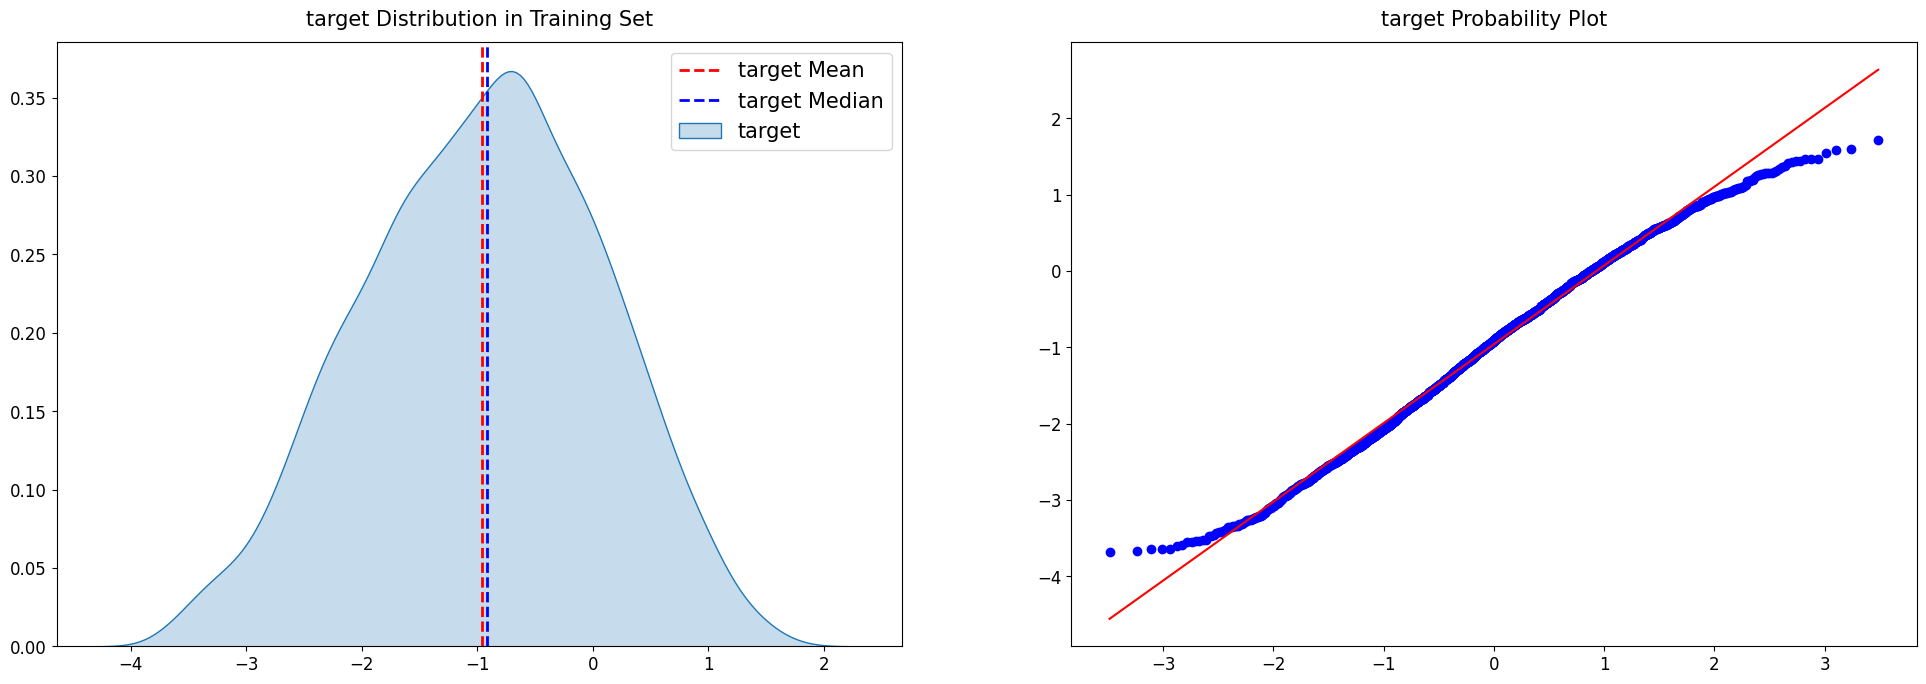

In [6]:
def plot_feature(target):
    
    print(f'{target}\n{"-" * len(target)}')
        
    print(f'Mean: {df_train[target].mean():.4f}  -  Median: {df_train[target].median():.4f}  -  Std: {df_train[target].std():.4f}')
    print(f'Min: {df_train[target].min():.4f}  -  25%: {df_train[target].quantile(0.25):.4f}  -  50%: {df_train[target].quantile(0.5):.4f}  -  75%: {df_train[target].quantile(0.75):.4f}  -  Max: {df_train[target].max():.4f}')
    print(f'Skew: {df_train[target].skew():.4f}  -  Kurtosis: {df_train[target].kurtosis():.4f}')
    missing_values_count = df_train[df_train[target].isnull()].shape[0]
    training_samples_count = df_train.shape[0]
    print(f'Missing Values: {missing_values_count}/{training_samples_count} ({missing_values_count * 100 / training_samples_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 8), dpi=100)
    sns.kdeplot(df_train[target], label=target, fill=True, ax=axes[0])
    axes[0].axvline(df_train[target].mean(), label=f'{target} Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df_train[target].median(), label=f'{target} Median', color='b', linewidth=2, linestyle='--')
    probplot(df_train[target], plot=axes[1])
    axes[0].legend(prop={'size': 15})
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[0].set_title(f'{target} Distribution in Training Set', fontsize=15, pad=12)
    axes[1].set_title(f'{target} Probability Plot', fontsize=15, pad=12)

    plt.show()

plot_feature('target')

`standard_error` is only provided for training set and it doesn't exist in hidden test set. Values of `standard_error` are between -0.428 and 0.6497 with mean of 0.4914 if the baseline excerpt is excluded. It can be used as a filter to drop uncertain samples from the dataset since it tells us how spread the rater scores are. Other than that, it doesn't have any additional information.

standard_error
--------------
Mean: 0.4914  -  Median: 0.4847  -  Std: 0.0348
Min: 0.0000  -  25%: 0.4685  -  50%: 0.4847  -  75%: 0.5063  -  Max: 0.6497
Skew: 0.2866  -  Kurtosis: 16.1271
Missing Values: 0/2834 (0.0000%)


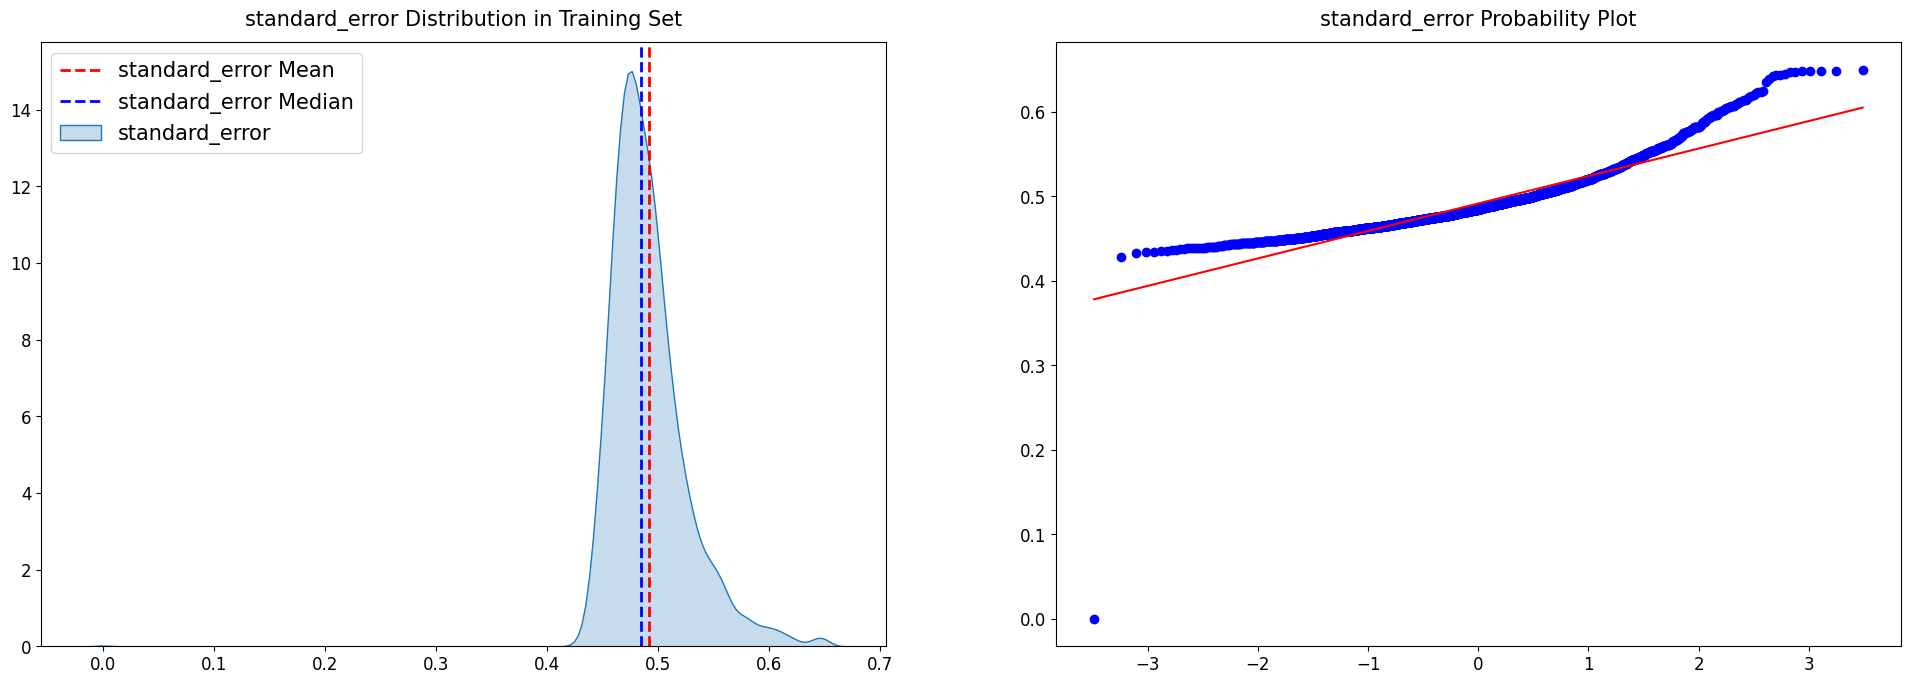

In [7]:
plot_feature('standard_error')

When `standard_error` is plotted against `target` without the baseline excerpt, a relationship can be seen. Excerpts with medium ease of read tend to have less spread of scores, however excerpts at both ends have more spread because they are either too easy or too hard for the raters. Raters' subjective opinions vary a lot when they rate those easy and hard excerpts, but they give closer opinions when the excerpts have medium difficulty.

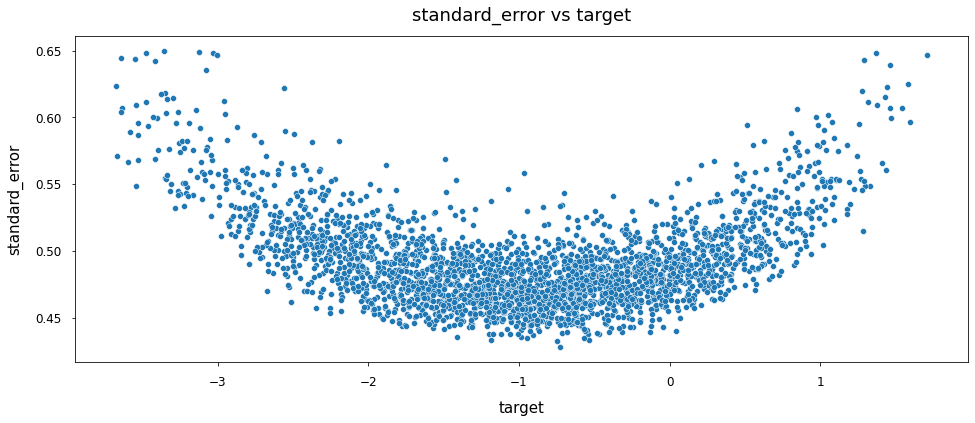

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
no_baseline = df_train['standard_error'] > 0
sns.scatterplot(x=df_train.loc[no_baseline, 'target'], y=df_train.loc[no_baseline, 'standard_error'], ax=ax)
ax.set_title(f'standard_error vs target', size=18, pad=15)
ax.set_xlabel('target', size=15, labelpad=12)
ax.set_ylabel('standard_error', size=15, labelpad=12)
ax.tick_params(axis='x', labelsize=12, pad=10)
ax.tick_params(axis='y', labelsize=12, pad=10)
plt.show()

## 4. Metadata

There are two additional features provided for training set, but they don't exist in hidden test set. Those features are `license` and `url_legal`. They are given for the same 830 excerpts and missing for the other 2004 excerpts.

There are 15 unique licenses for materials and there are 15 unique websites from which the excerpts are taken from. `license` feature doesn't contain any useful information but `url_legal` might give some clues about the excerpts. Some of the excerpts are taken from educational websites for kids and those excerpts are probably written in a way to be more readable compared to excerpts taken from the other websites.

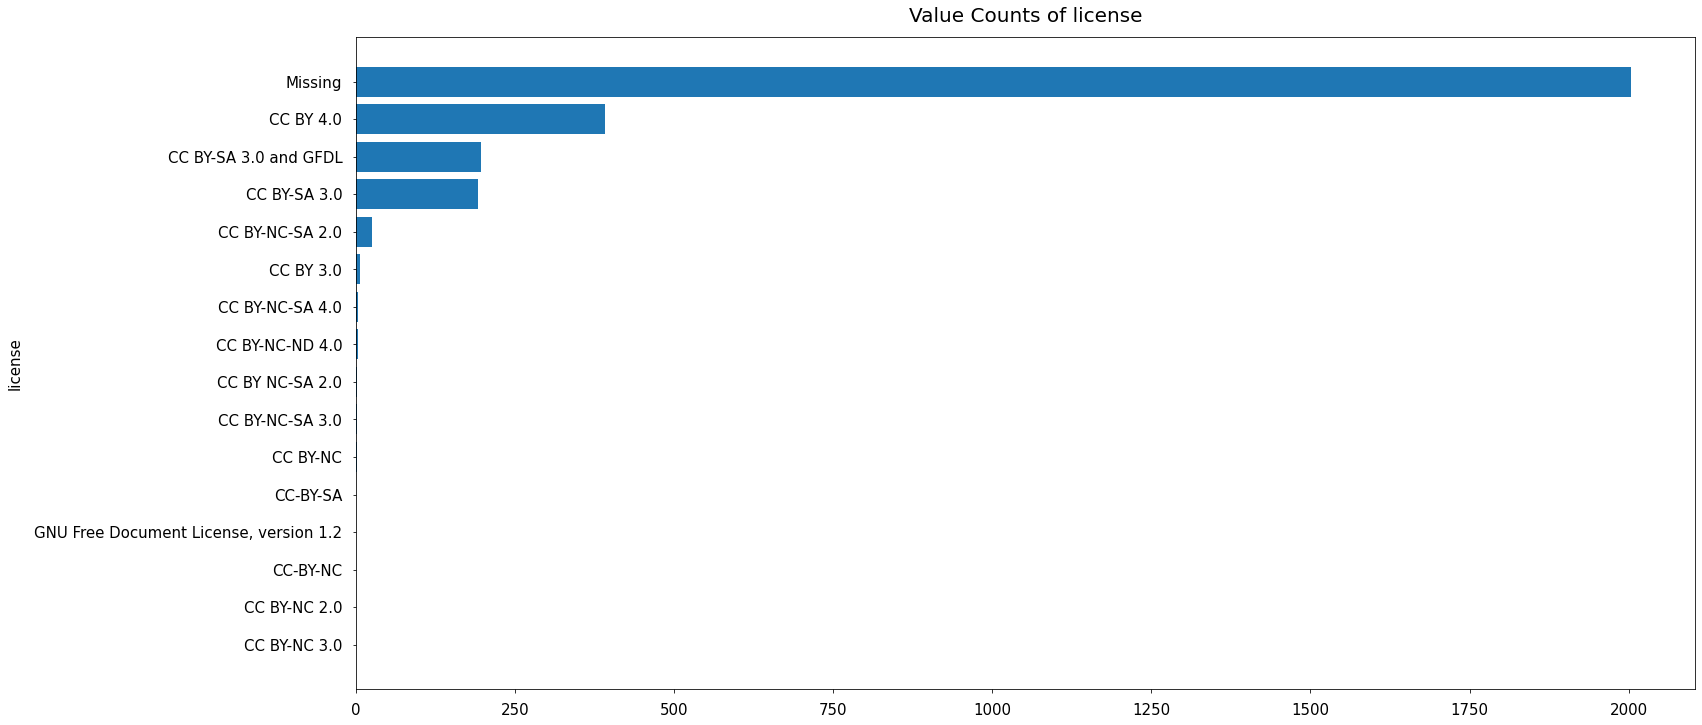

In [9]:
fig, ax = plt.subplots(figsize=(24, 12))

ax.barh(y=df_train['license'].fillna('Missing').value_counts().sort_values(ascending=True).index,
        width=df_train['license'].fillna('Missing').value_counts().sort_values(ascending=True).values,
        align='center')

ax.set_ylabel('license', size=15, labelpad=12)
ax.tick_params(axis='x', labelsize=15, pad=10)
ax.tick_params(axis='y', labelsize=15, pad=10)
ax.set_title('Value Counts of license', size=20, pad=15)

plt.show()

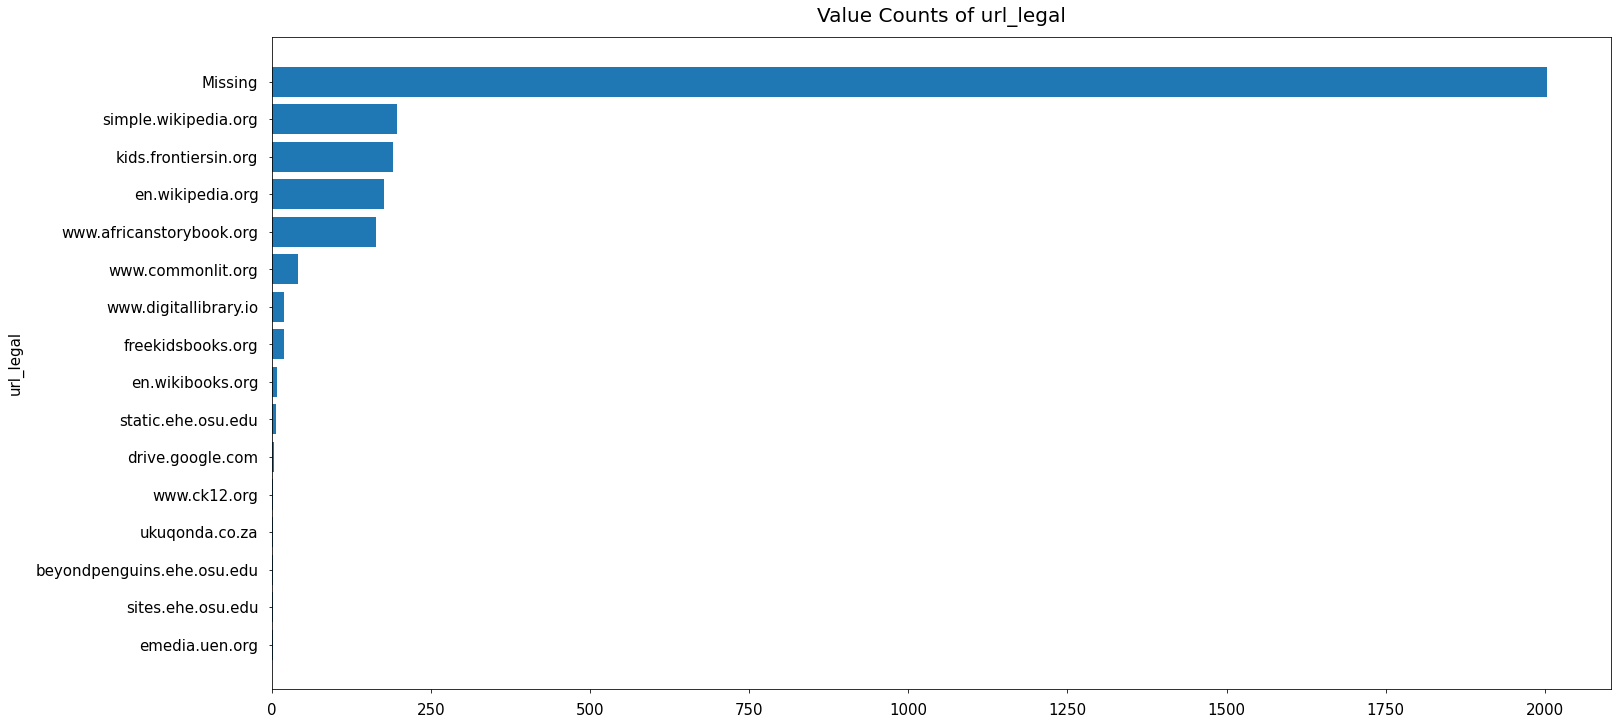

In [10]:
fig, ax = plt.subplots(figsize=(24, 12))

website_urls = df_train['url_legal'].fillna('/ /Missing').apply(lambda x: str(x).split('/')[2])
ax.barh(y=website_urls.value_counts().sort_values(ascending=True).index,
        width=website_urls.value_counts().sort_values(ascending=True).values,
        align='center')

ax.set_ylabel('url_legal', size=15, labelpad=12)
ax.tick_params(axis='x', labelsize=15, pad=10)
ax.tick_params(axis='y', labelsize=15, pad=10)
ax.set_title('Value Counts of url_legal', size=20, pad=15)

plt.show()

## 5. Excerpts

There are 2834 excerpts in training set and approximately 2000 excerpts in hidden test set. They are taken from various sources that can be seen above, and they are ranked by ease of read compared to baseline excerpt. Hardest and easiest to read excerpts are displayed along with the baseline excerpt below.

Easiest excerpt to read (`25ca8f498`) is a very plain text. Information is given in a very straightforward manner. Sentences are short, diction and syntax are elementary level. There are no excessive amount of conjunctions and punctuations.

Hardest excerpt to read (`4626100d8`) is in fact hard to understand. Sentences are long, diction and syntax are academic level. There are lots sentences connected to each with conjunctions and lots of punctuations.

These insights can be useful for feature engineering.

In [11]:
easiest_excerpt = df_train[df_train['target'] == df_train['target'].max()]
print(f'Easiest excerpt to read {easiest_excerpt["id"].values[0]} (Target: {easiest_excerpt["target"].values[0]:.6})\n{"-" * 51}')
print(easiest_excerpt['excerpt'].values[0])

baseline_excerpt = df_train[df_train['target'] == 0]
print(f'\nBaseline excerpt {baseline_excerpt["id"].values[0]} (Target: 0)\n{"-" * 38}')
print(baseline_excerpt['excerpt'].values[0])

hardest_excerpt = df_train[df_train['target'] == df_train['target'].min()]
print(f'\nHardest excerpt to read {hardest_excerpt["id"].values[0]} (Target: {hardest_excerpt["target"].values[0]:.6})\n{"-" * 52}')
print(hardest_excerpt['excerpt'].values[0])

Easiest excerpt to read 25ca8f498 (Target: 1.71139)
---------------------------------------------------
When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?
This surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.
One of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must 

After tokenization, average sequence length is 200 with 21.6 standard deviation. Shortest sequence has 151 tokens and longest sequence has 270 tokens. Distribution of sequence length is quite symmetrical and same properties are expected in the hidden test set.

sequence_length
---------------
Mean: 199.6468  -  Median: 200.0000  -  Std: 21.6073
Min: 151.0000  -  25%: 183.0000  -  50%: 200.0000  -  75%: 215.0000  -  Max: 270.0000
Skew: 0.0919  -  Kurtosis: -0.4984
Missing Values: 0/2834 (0.0000%)


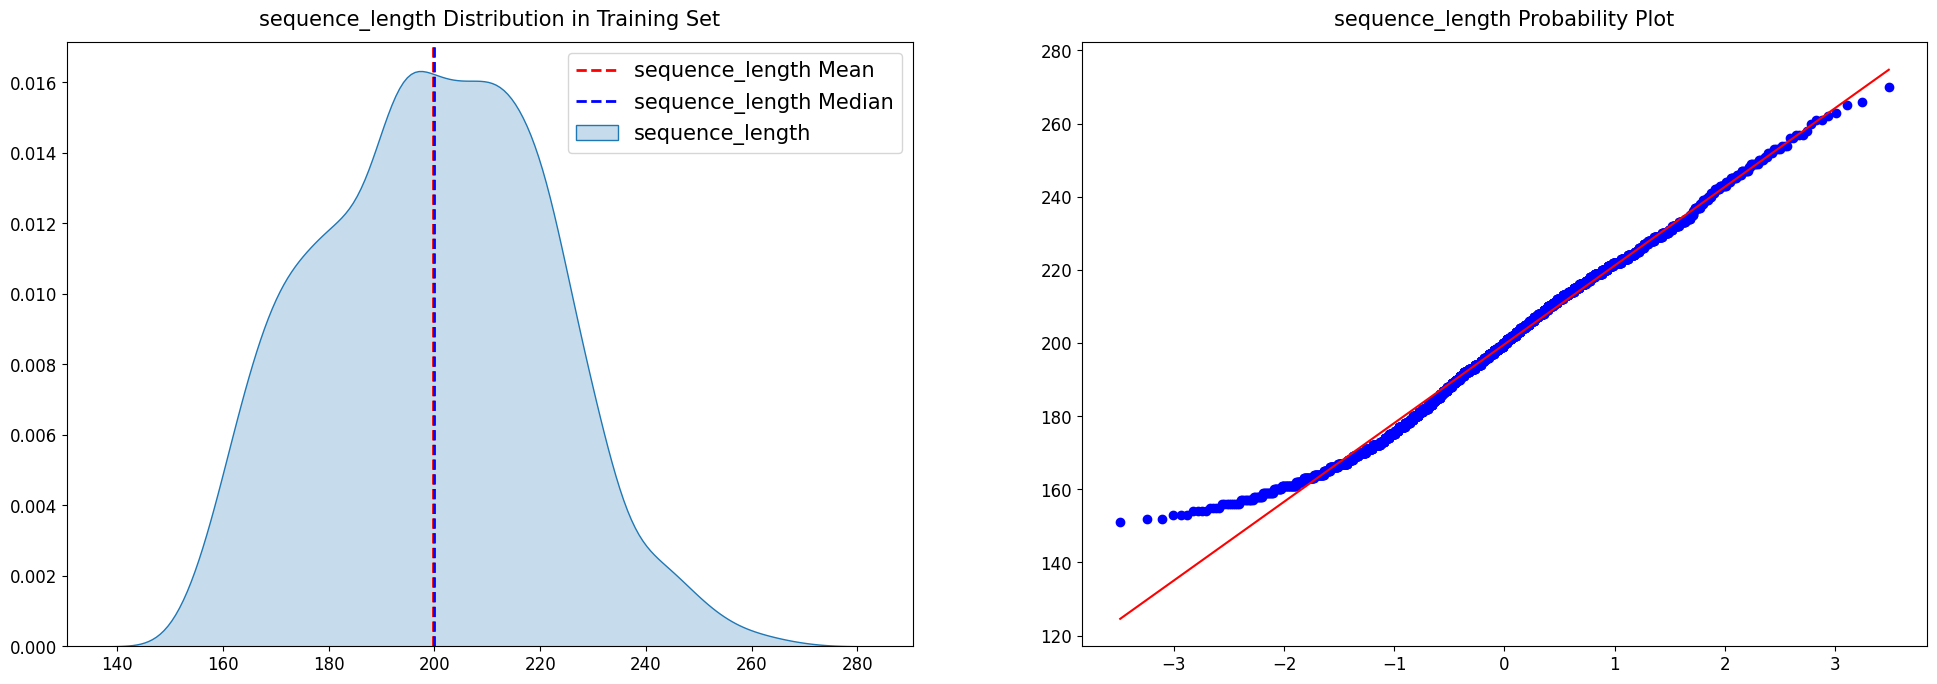

In [12]:
df_train['sequence_length'] = df_train['excerpt'].apply(lambda x: len(word_tokenize(str(x))))
plot_feature('sequence_length')
df_train.drop(columns=['sequence_length'], inplace=True)

Word clouds from both sides of the spectrum are drawn below. There is no visible difference in wordclouds since both easier and harder excerpts mostly have same type of common words. However, when the words are selected from both ends of the spectrum, a clear difference could be visible.

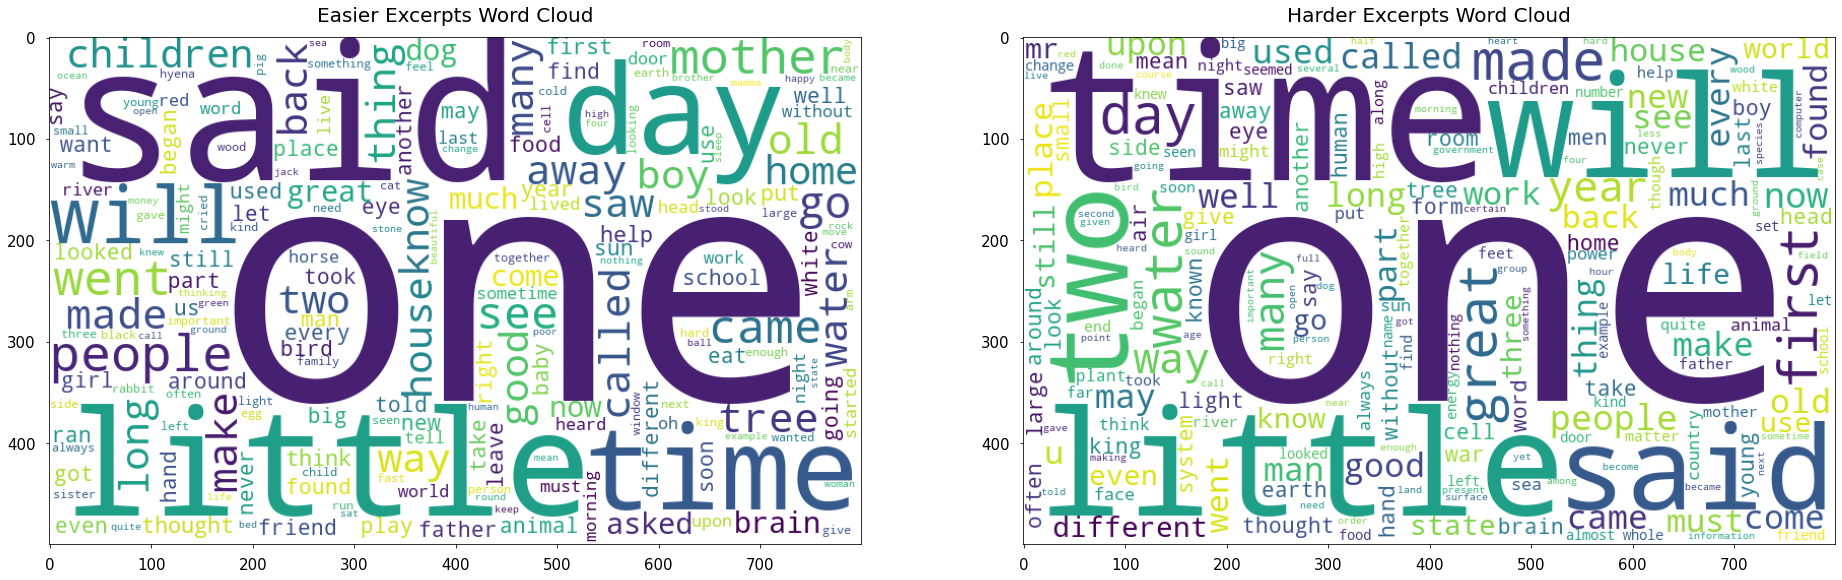

In [13]:
def clean_text(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[\.\,]', '', text)
    text = text.lower()
    return text

df_train['excerpt_clean'] = df_train['excerpt'].apply(clean_text)
easier_words = ' '.join(df_train[df_train['target'] > 0]['excerpt_clean'].values)
harder_words = ' '.join(df_train[df_train['target'] < 0]['excerpt_clean'].values)

easier_words_wordcloud = WordCloud(width=800,
                                   height=500,
                                   stopwords=STOPWORDS,
                                   random_state=42,
                                   background_color='white',
                                   collocations=False).generate(easier_words)
harder_words_wordcloud = WordCloud(width=800,
                                   height=500,
                                   stopwords=STOPWORDS,
                                   random_state=42,
                                   background_color='white',
                                   collocations=False).generate(harder_words)

fig, axes = plt.subplots(ncols=2, figsize=(32, 10))
axes[0].imshow(easier_words_wordcloud)
axes[1].imshow(harder_words_wordcloud)
for i in range(2):
    axes[i].tick_params(axis='x', labelsize=15, pad=10)
    axes[i].tick_params(axis='y', labelsize=15, pad=10)    
axes[0].set_title('Easier Excerpts Word Cloud', size=20, pad=15)
axes[1].set_title('Harder Excerpts Word Cloud', size=20, pad=15)
plt.show()

## 6. N-grams

As the word clouds weren't sufficient for displaying the differences between easier and harder excerpts, function `generate_ngrams` is used for generating n-grams for both easier and harder excerpts. After the n-grams are generated, most common 100 of them are plotted with their frequencies for both easier and harder excerpts.

In [14]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

df_train['excerpt_clean'] = df_train['excerpt'].apply(clean_text)
easier_excerpts = df_train['target'] > 0
harder_excerpts = df_train['target'] < 0
n = 100

### 6.1. Unigrams

Most common unigrams in easier and harder excerpts are very similar, so they don't give much information about the readability. There is no syntactically hard word in harder excerpts in most common unigrams. It may be due to semantics is more important than syntax for readability or syntactically harder words are basically less common in the vocabulary so they are at the bottom of the list.

In [15]:
easier_unigrams = defaultdict(int)
harder_unigrams = defaultdict(int)

for excerpt in df_train.loc[easier_excerpts, 'excerpt']:
    for word in generate_ngrams(excerpt):
        easier_unigrams[word] += 1
        
for excerpt in df_train.loc[harder_excerpts, 'excerpt']:
    for word in generate_ngrams(excerpt):
        harder_unigrams[word] += 1
        
df_easier_unigrams = pd.DataFrame(sorted(easier_unigrams.items(), key=lambda x: x[1])[::-1])
df_harder_unigrams = pd.DataFrame(sorted(harder_unigrams.items(), key=lambda x: x[1])[::-1])

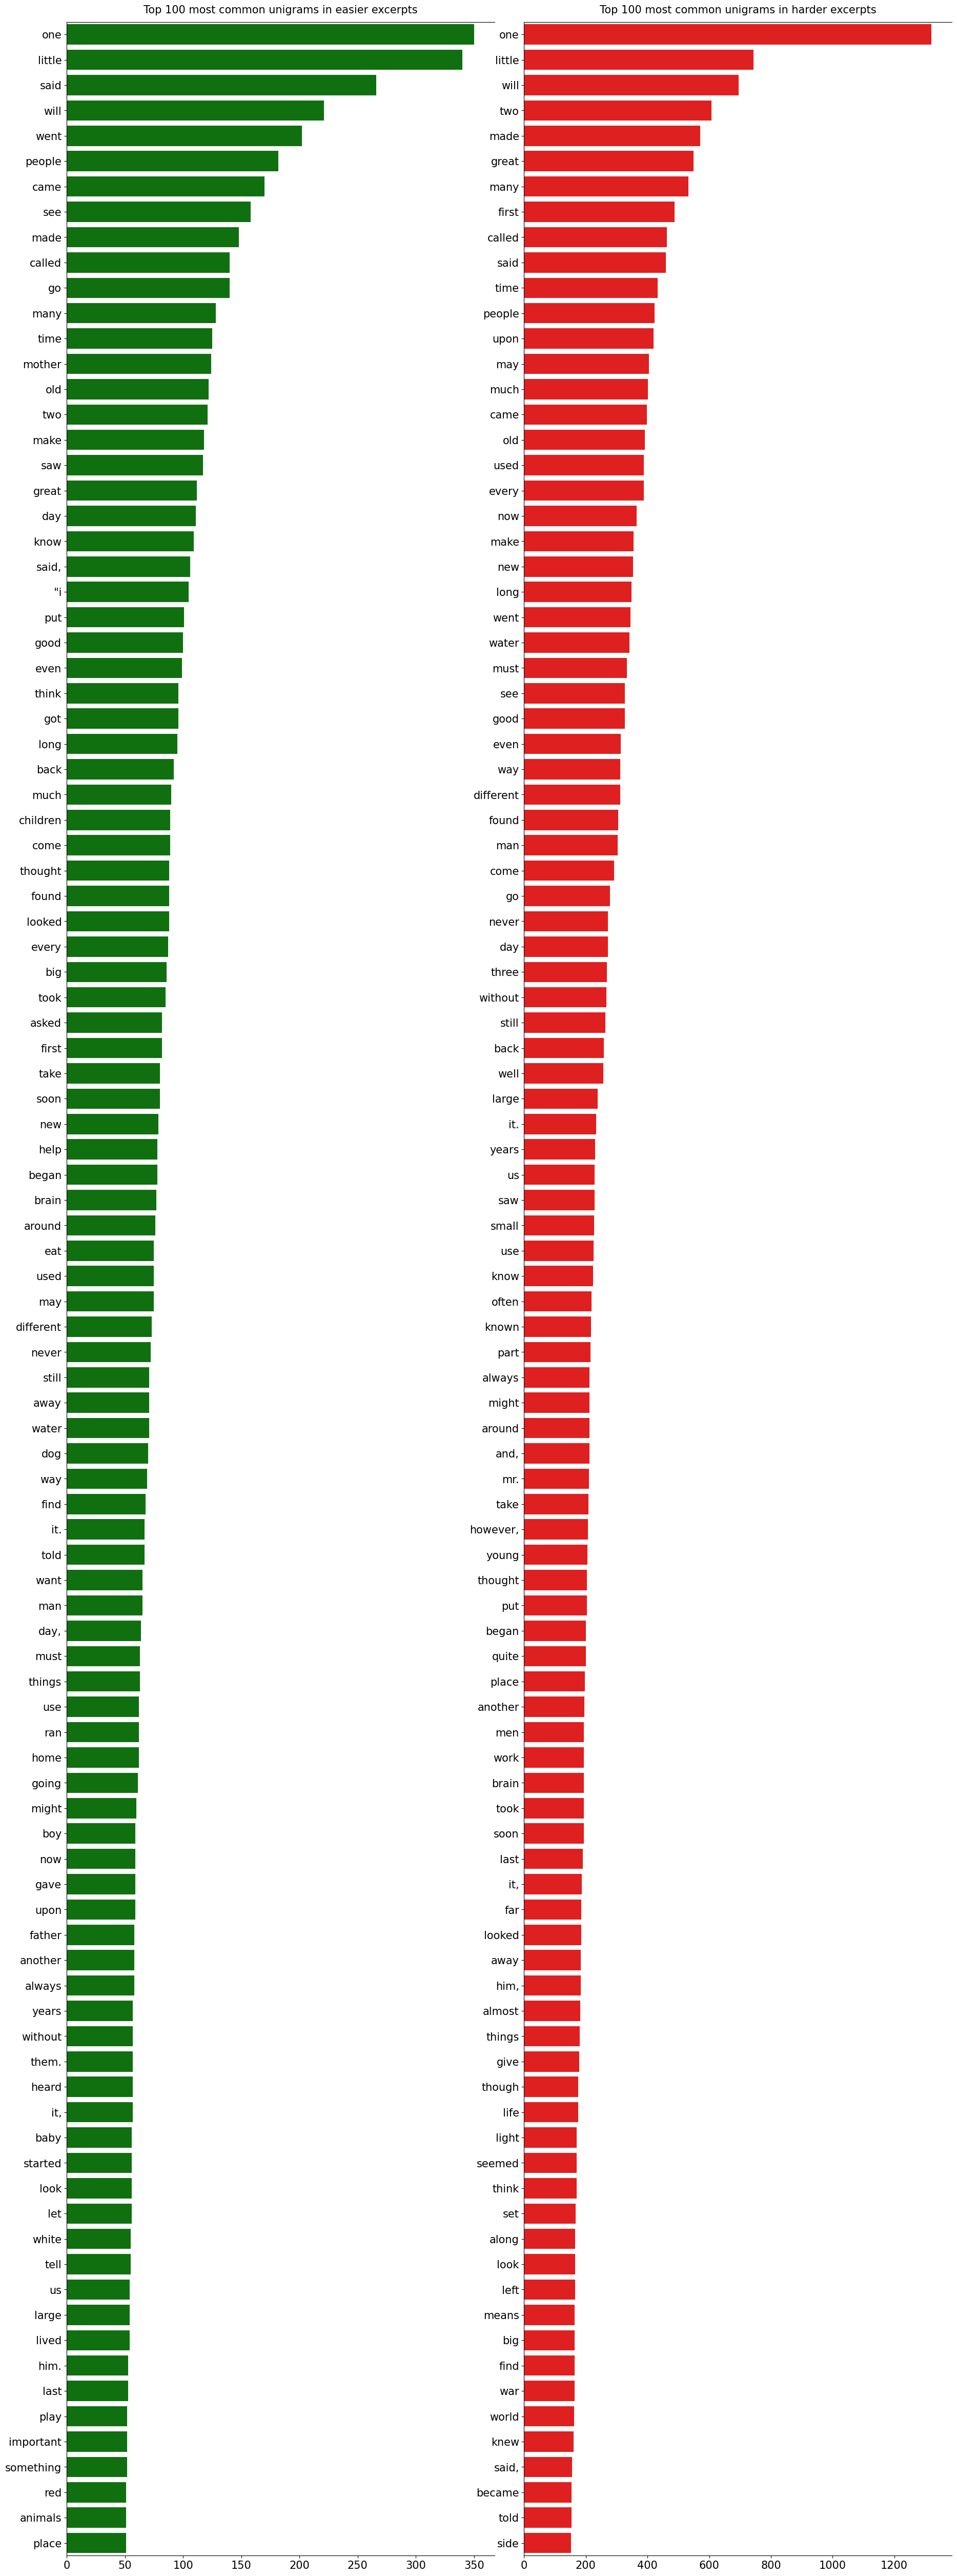

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_easier_unigrams[0].values[:n], x=df_easier_unigrams[1].values[:n], ax=axes[0], color='green')
sns.barplot(y=df_harder_unigrams[0].values[:n], x=df_harder_unigrams[1].values[:n], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {n} most common unigrams in easier excerpts', fontsize=15, pad=12)
axes[1].set_title(f'Top {n} most common unigrams in harder excerpts', fontsize=15, pad=12)

plt.show()

### 6.2. Bigrams

Some of the most common bigrams can be seen in both easier and harder excerpts, but syntactically harder ones are slightly more common in harder excerpts.

In [17]:
easier_bigrams = defaultdict(int)
harder_bigrams = defaultdict(int)

for excerpt in df_train.loc[easier_excerpts, 'excerpt']:
    for word in generate_ngrams(excerpt, n_gram=2):
        easier_bigrams[word] += 1
        
for excerpt in df_train.loc[harder_excerpts, 'excerpt']:
    for word in generate_ngrams(excerpt, n_gram=2):
        harder_bigrams[word] += 1
        
df_easier_bigrams = pd.DataFrame(sorted(easier_bigrams.items(), key=lambda x: x[1])[::-1])
df_harder_bigrams = pd.DataFrame(sorted(harder_bigrams.items(), key=lambda x: x[1])[::-1])

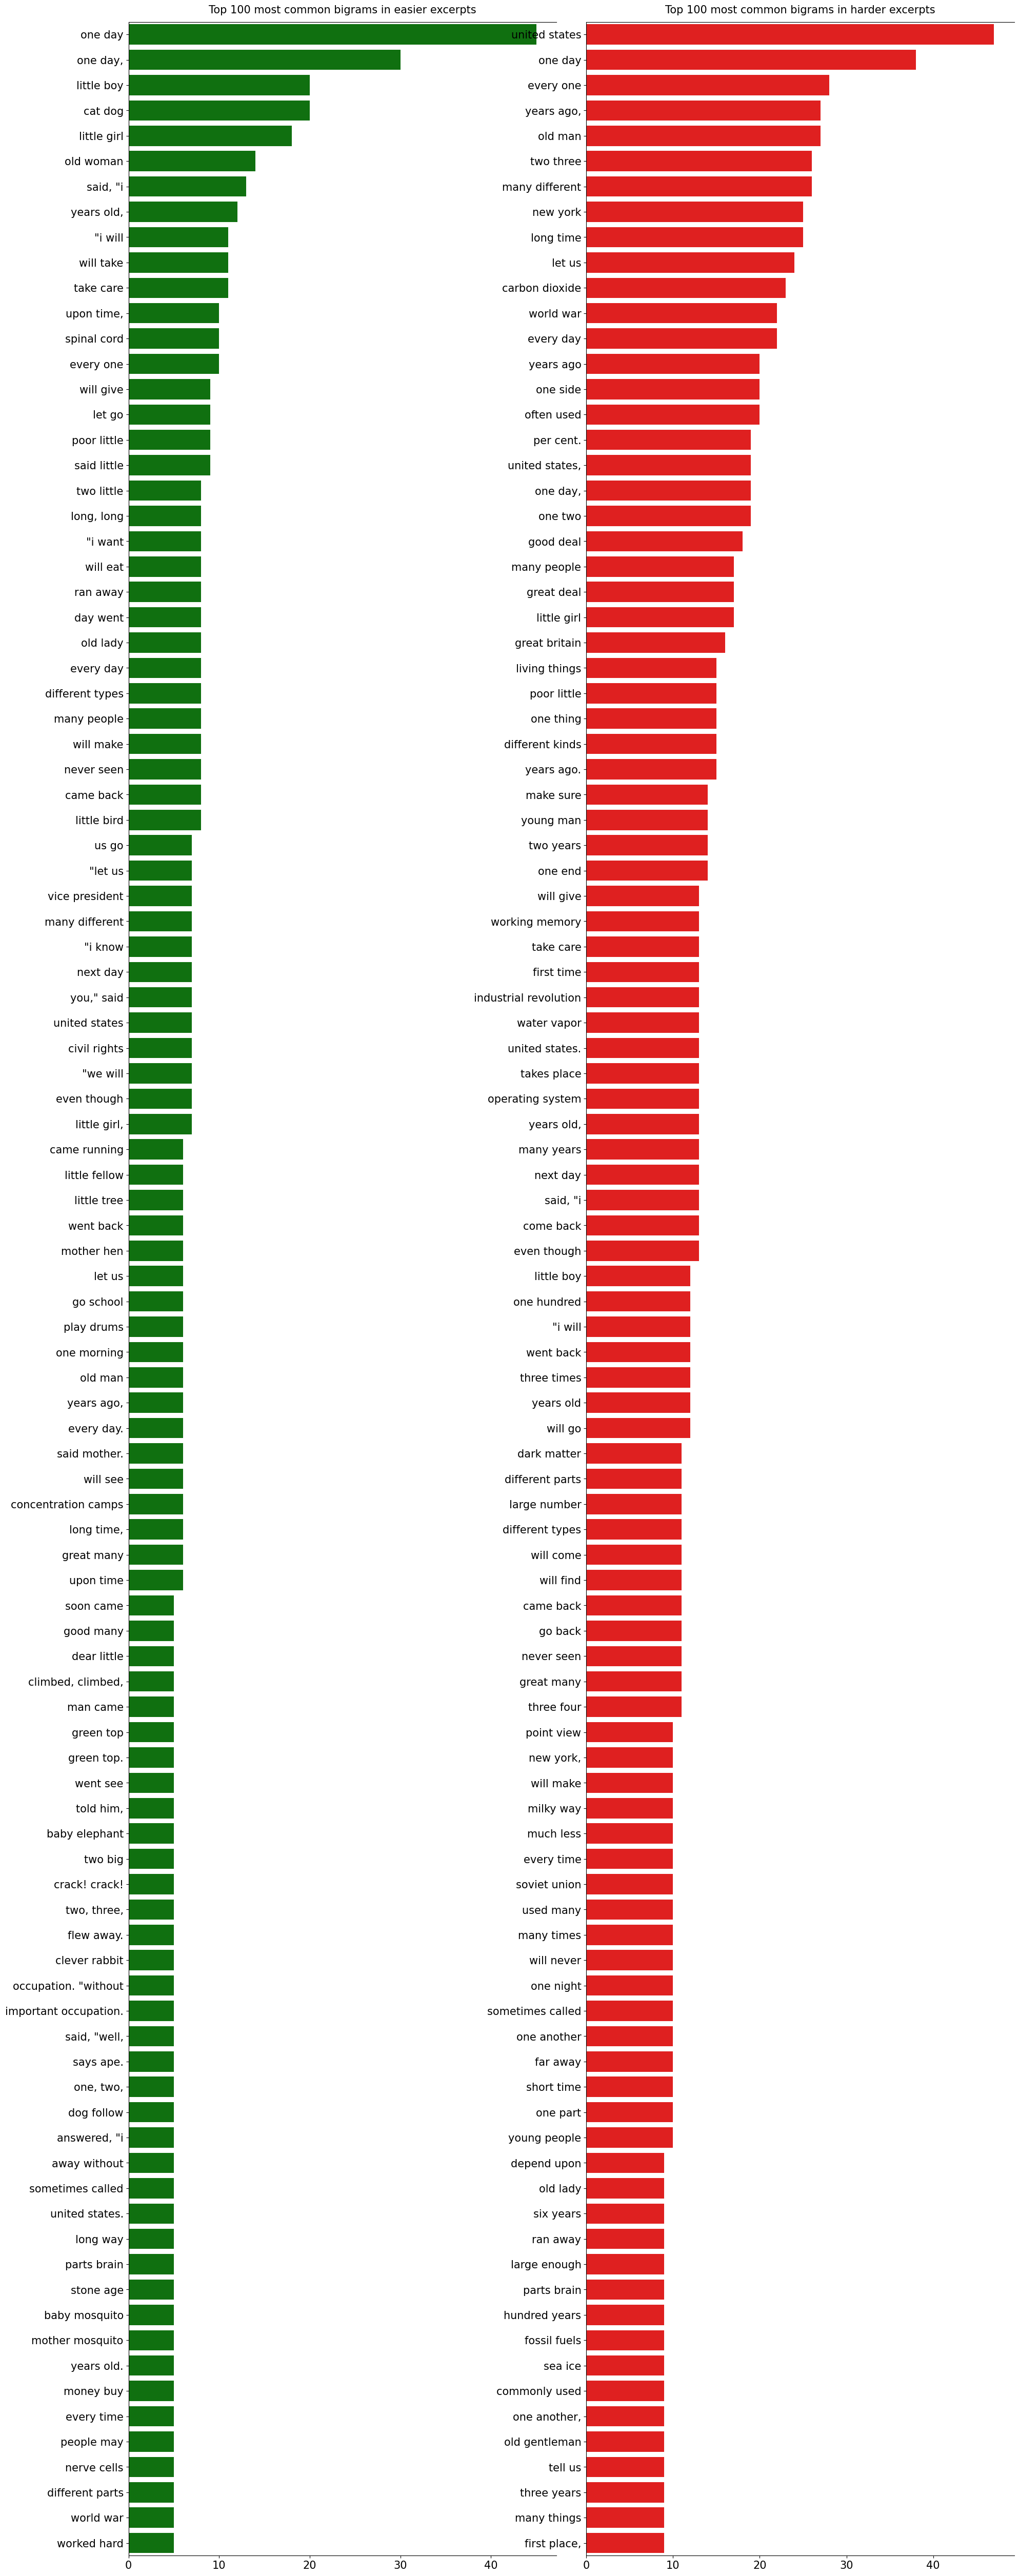

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_easier_bigrams[0].values[:n], x=df_easier_bigrams[1].values[:n], ax=axes[0], color='green')
sns.barplot(y=df_harder_bigrams[0].values[:n], x=df_harder_bigrams[1].values[:n], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {n} most common bigrams in easier excerpts', fontsize=15, pad=12)
axes[1].set_title(f'Top {n} most common bigrams in harder excerpts', fontsize=15, pad=12)

plt.show()

### 6.3. Trigrams

Most common trigrams in both easier and harder excerpts don't have any information about readability because their frequencies are very low. Thus, they could be noise.

In [19]:
easier_trigrams = defaultdict(int)
harder_trigrams = defaultdict(int)

for excerpt in df_train.loc[easier_excerpts, 'excerpt']:
    for word in generate_ngrams(excerpt, n_gram=3):
        easier_trigrams[word] += 1
        
for excerpt in df_train.loc[harder_excerpts, 'excerpt']:
    for word in generate_ngrams(excerpt, n_gram=3):
        harder_trigrams[word] += 1
        
df_easier_trigrams = pd.DataFrame(sorted(easier_trigrams.items(), key=lambda x: x[1])[::-1])
df_harder_trigrams = pd.DataFrame(sorted(harder_trigrams.items(), key=lambda x: x[1])[::-1])

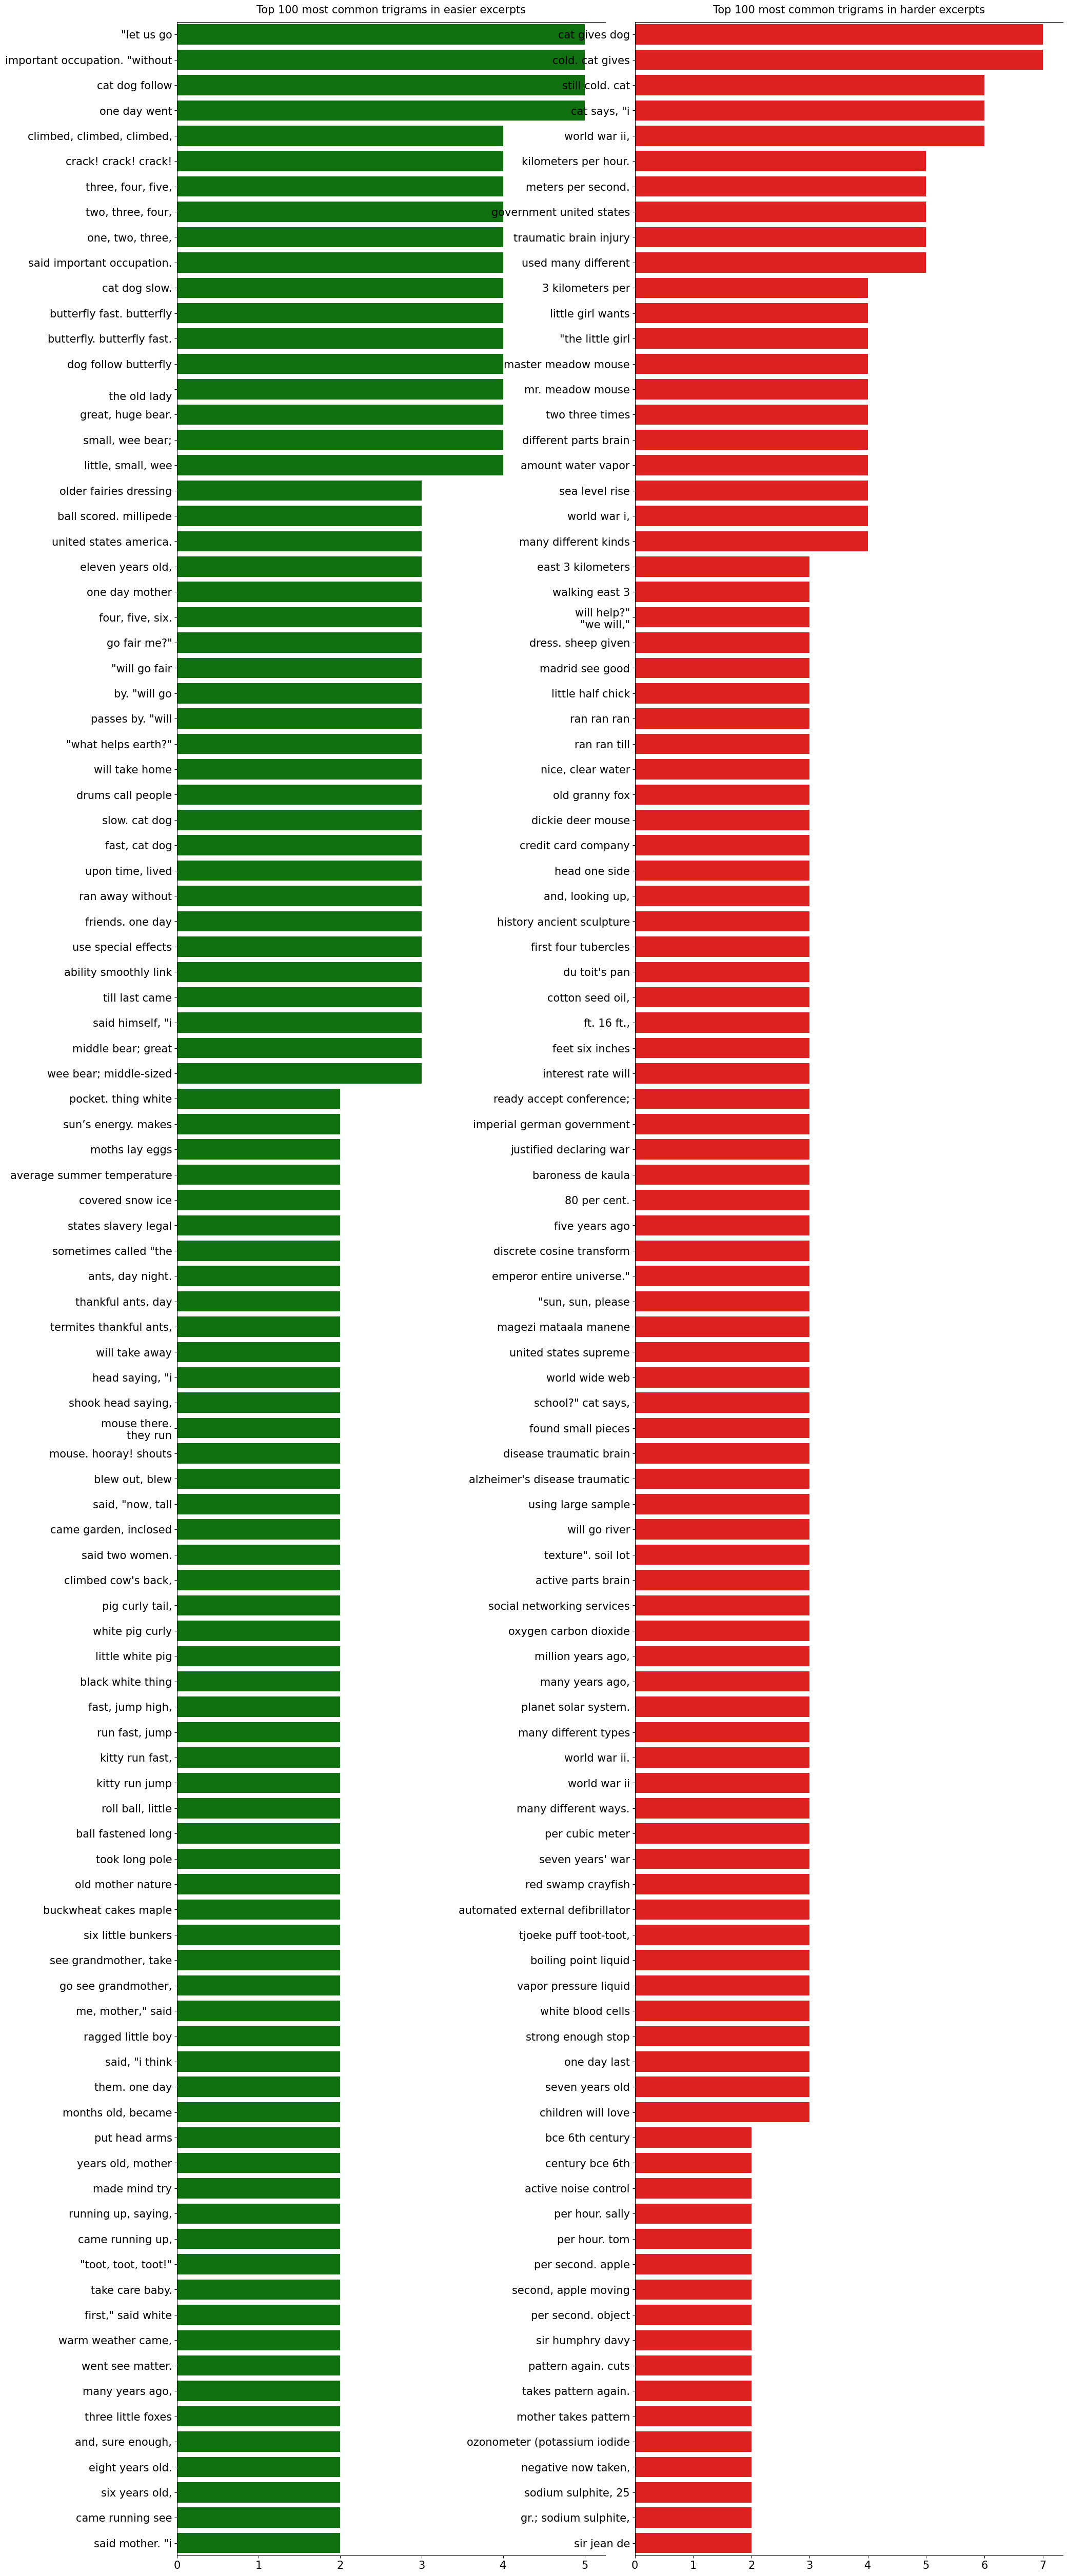

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_easier_trigrams[0].values[:n], x=df_easier_trigrams[1].values[:n], ax=axes[0], color='green')
sns.barplot(y=df_harder_trigrams[0].values[:n], x=df_harder_trigrams[1].values[:n], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {n} most common trigrams in easier excerpts', fontsize=15, pad=12)
axes[1].set_title(f'Top {n} most common trigrams in harder excerpts', fontsize=15, pad=12)

plt.show()

## 7. Feature Engineering

13 new features are created from excerpts with the help of [textstat](https://github.com/shivam5992/textstat) package. textstat is a very simple package that can be used for calculating statistics from texts. Features created with textstat are:

* `character_count` number of characters in the text
* `digit_count` number of digits in the text
* `word_count` number of words in the text
* `unique_word_count` number of unique words in the text
* `mean_word_length` average number of character that the words have in the text
* `syllable_count` number of syllables in the text
* `sentence_count` number of sentences in the text
* `flesch_reading_ease` [flesch reading ease score](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease) of the text
* `flesch_kincaid_grade` [flesch-kincaid grade level](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level) of the text
* `smog_index` [smog index](https://en.wikipedia.org/wiki/SMOG) of the text
* `automated_readability_index` [automated readability index](https://en.wikipedia.org/wiki/Automated_readability_index) of the text
* `coleman_liau_index` [coleman–liau index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index) of the text
* `linsear_write_formula` [linsear write grade](hlinsear_write_formulattps://en.wikipedia.org/wiki/Linsear_Write) of the text

In [21]:
df_train['character_count'] = df_train['excerpt'].apply(lambda x: len(str(x)))
df_train['digit_count'] = df_train['excerpt'].apply(lambda x: np.sum(([int(word.isdigit()) for word in str(x).split()])))
df_train['word_count'] = df_train['excerpt'].apply(textstat.lexicon_count)
df_train['unique_word_count'] = df_train['excerpt'].apply(lambda x: len(set(str(x).split())))
df_train['mean_word_length'] = df_train['excerpt'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
df_train['syllable_count'] = df_train['excerpt'].apply(textstat.syllable_count)
df_train['sentence_count'] = df_train['excerpt'].apply(textstat.sentence_count)
df_train['flesch_reading_ease'] = df_train['excerpt'].apply(textstat.flesch_reading_ease)
df_train['flesch_kincaid_grade'] = df_train['excerpt'].apply(textstat.flesch_kincaid_grade)
df_train['smog_index'] = df_train['excerpt'].apply(textstat.smog_index)
df_train['automated_readability_index'] = df_train['excerpt'].apply(textstat.automated_readability_index)
df_train['coleman_liau_index'] = df_train['excerpt'].apply(textstat.coleman_liau_index)
df_train['linsear_write_formula'] = df_train['excerpt'].apply(textstat.linsear_write_formula)

features = [
    'character_count',
    'digit_count',
    'word_count',
    'unique_word_count',
    'mean_word_length',
    'syllable_count',
    'sentence_count',
    'flesch_reading_ease',
    'flesch_kincaid_grade',
    'smog_index',
    'automated_readability_index',
    'coleman_liau_index',
    'linsear_write_formula',
]

`flesch_reading_ease` and `smog_index` are the most correlated features with target with 0.52 and -0.53 correlation coefficients respectively. Other features are slightly correlated with target, but they can be still useful for models. Some of the new features are extremely correlated with each other so they may have the curse of dimensionality.

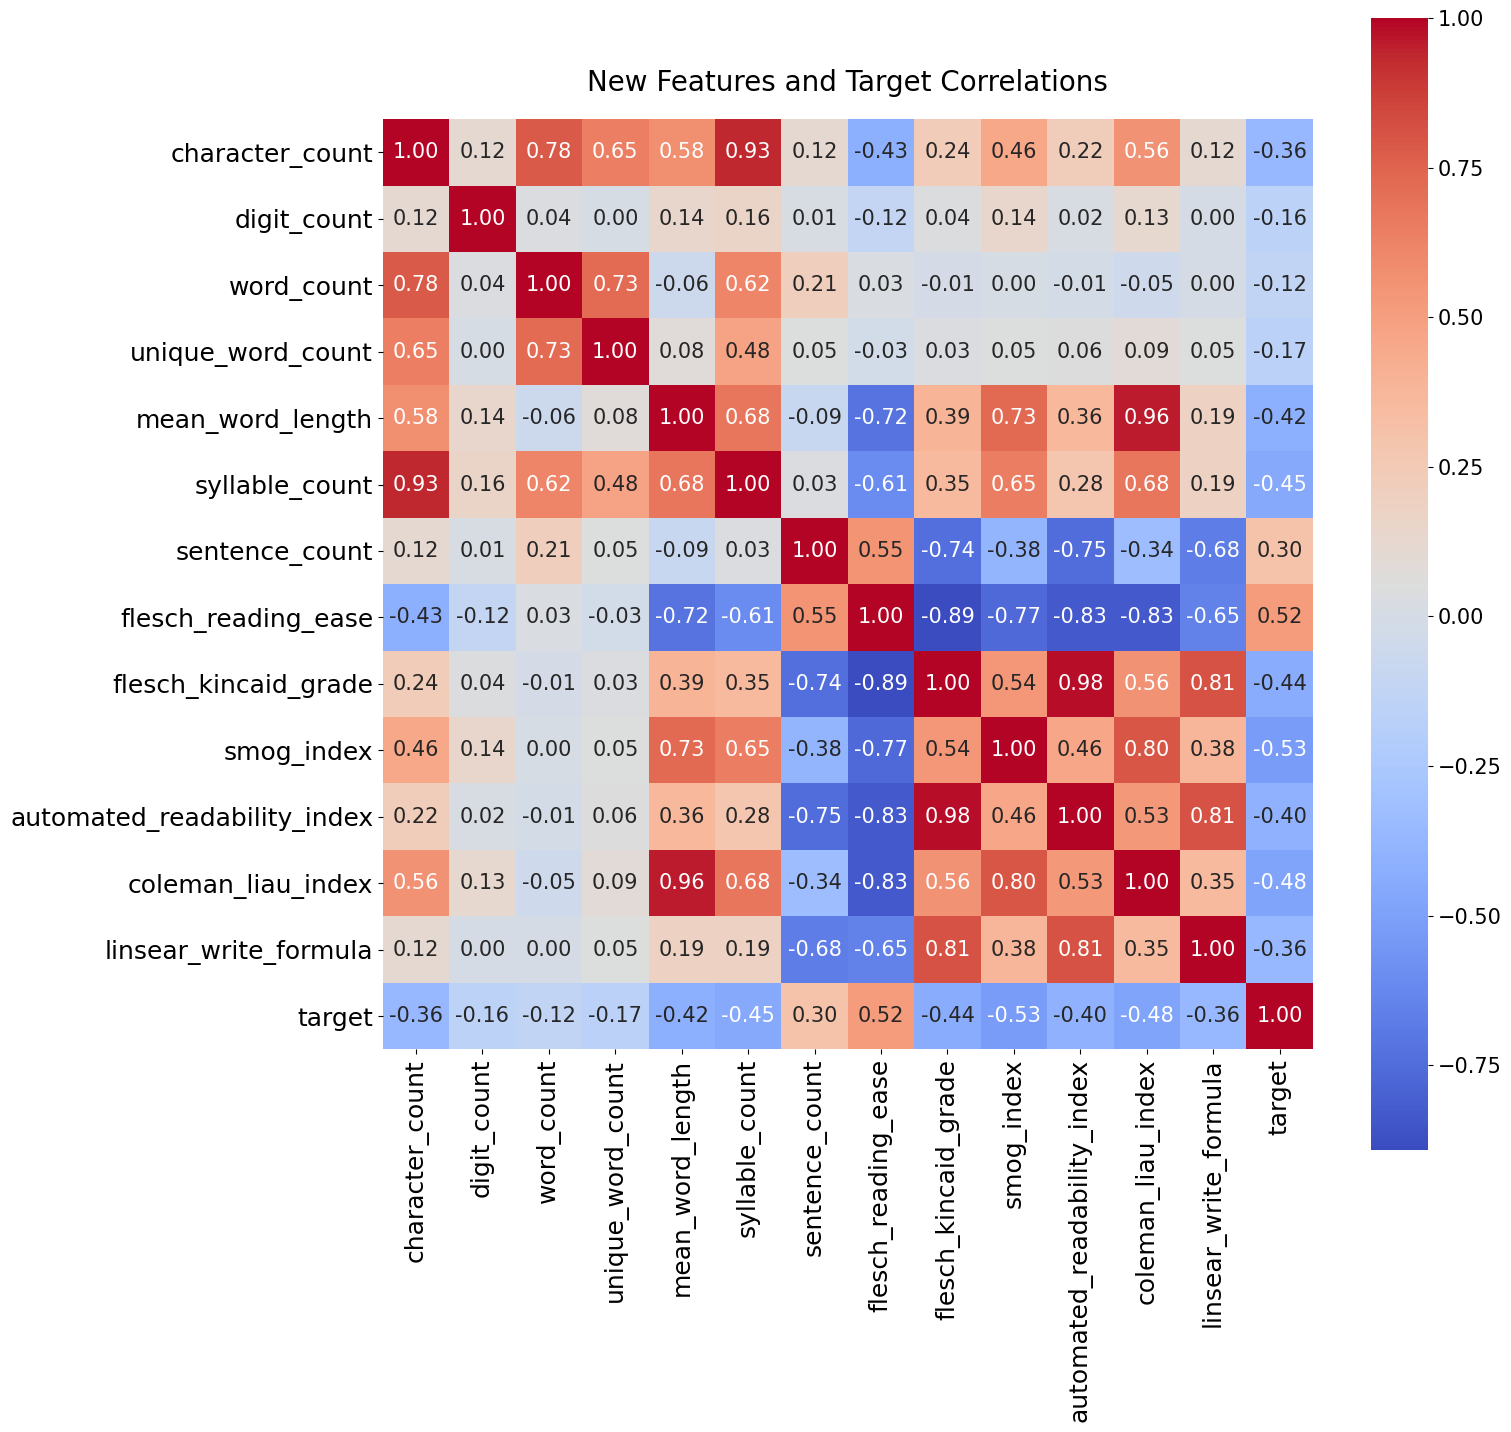

In [22]:
fig = plt.figure(figsize=(15, 15), dpi=100)

ax = sns.heatmap(df_train[features + ['target']].corr(),
                 annot=True,
                 square=True,
                 cmap='coolwarm',
                 annot_kws={'size': 15},
                 fmt='.2f')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.tick_params(axis='x', labelsize=18, rotation=90)
plt.tick_params(axis='y', labelsize=18, rotation=0)
plt.title('New Features and Target Correlations', size=20, pad=20)
plt.show()

Strong positive and negative relationships can be seen from the scatter plots of `flesch_reading_ease` and `smog_index`. Other features don't look very promising from their skewed distributions and weak relationships, but they can be still useful in terms of predictive power.

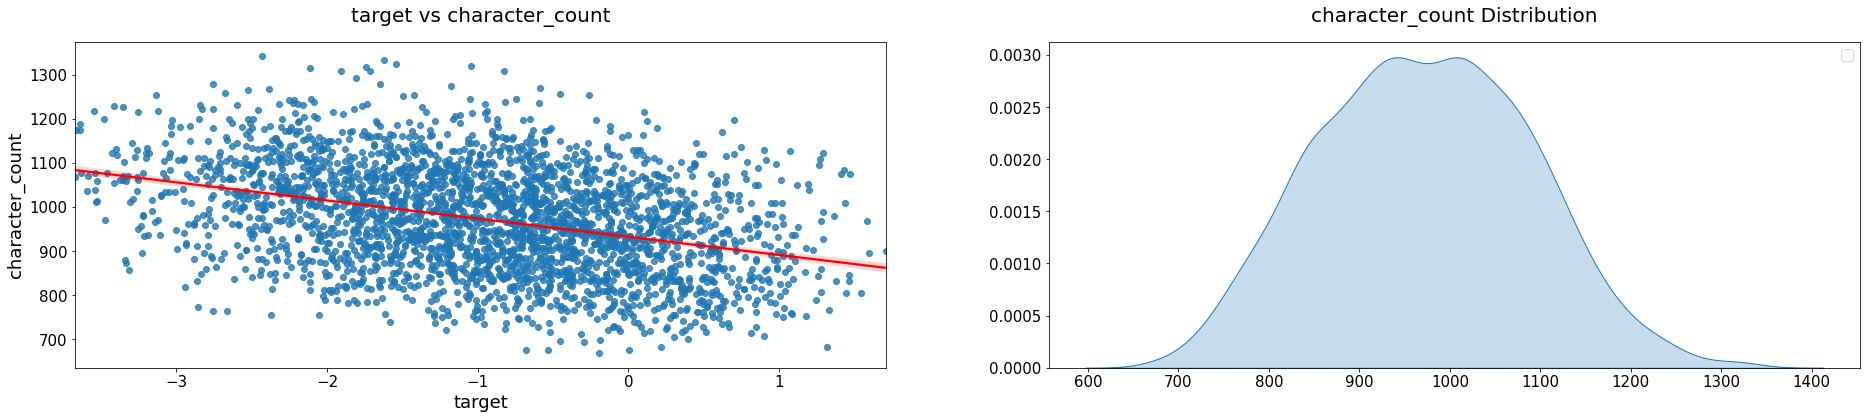

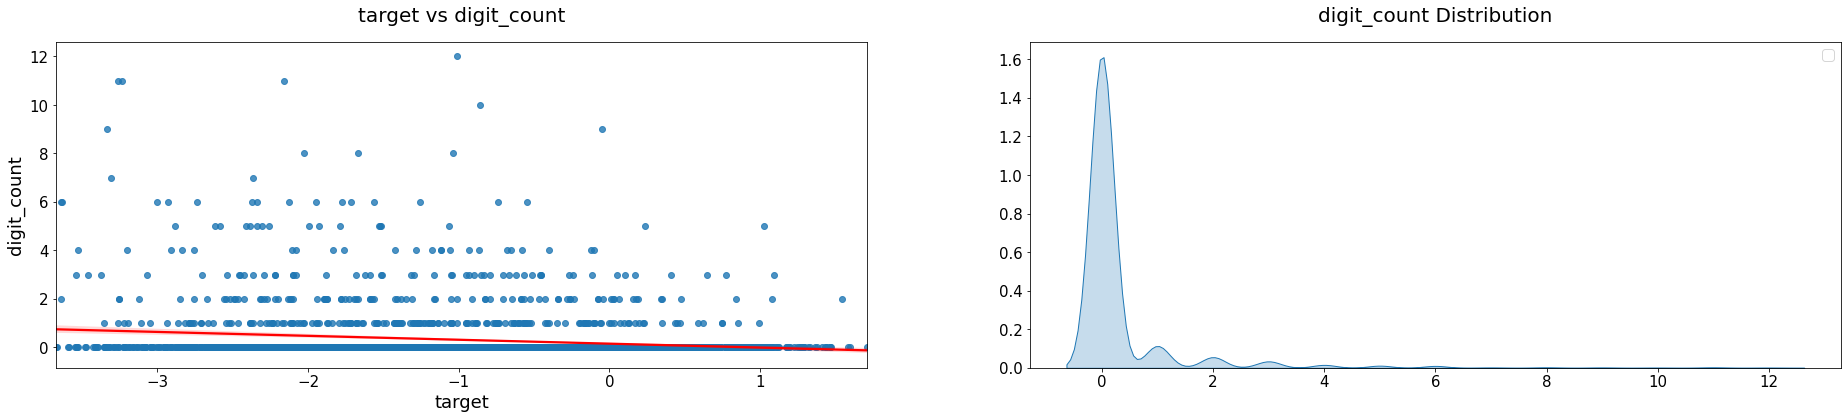

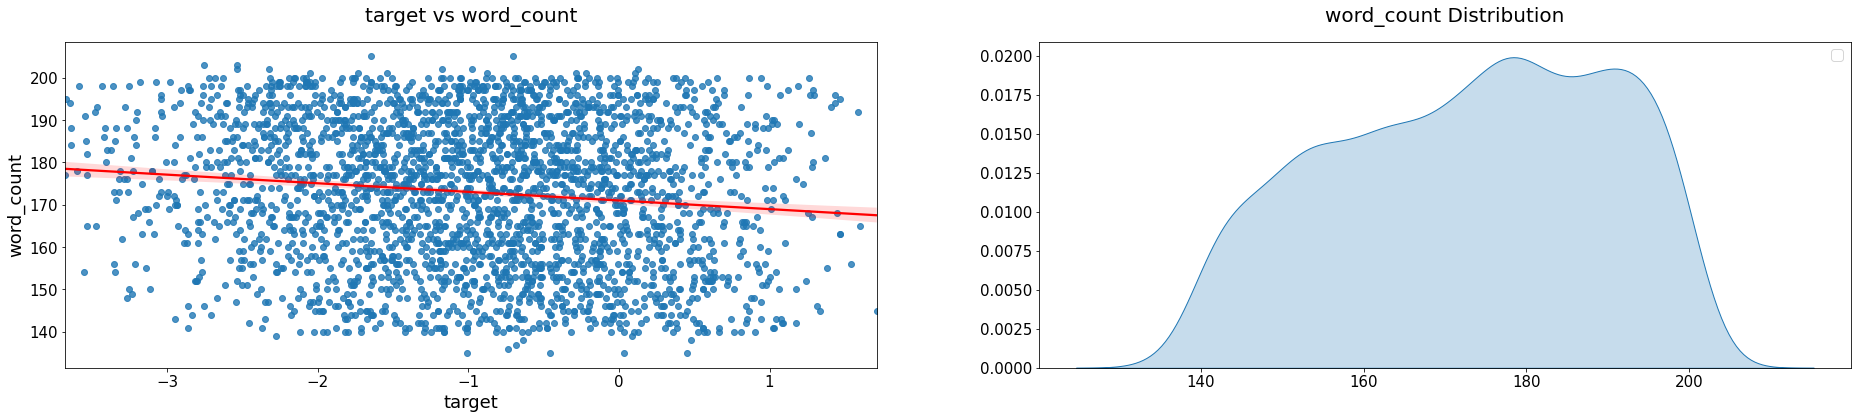

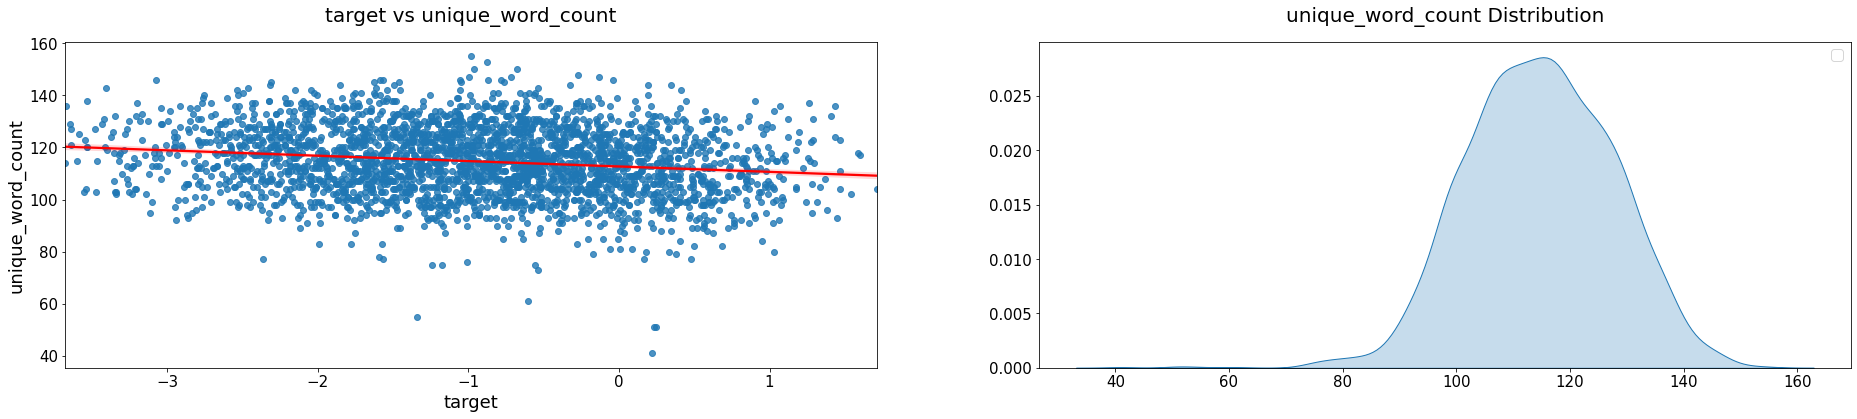

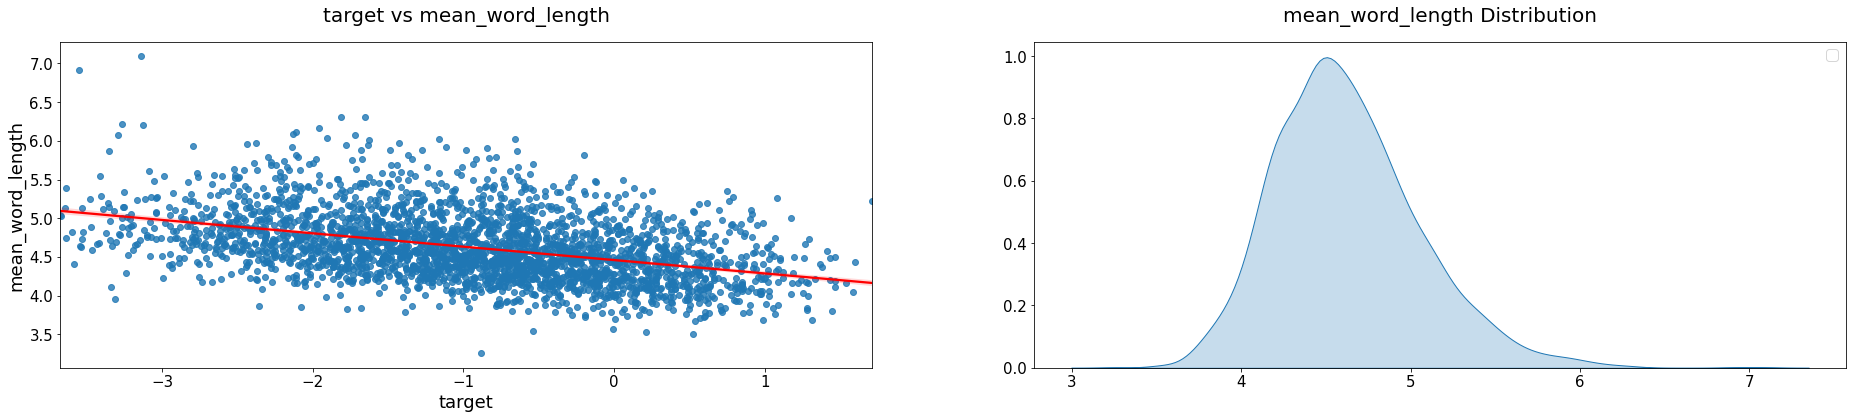

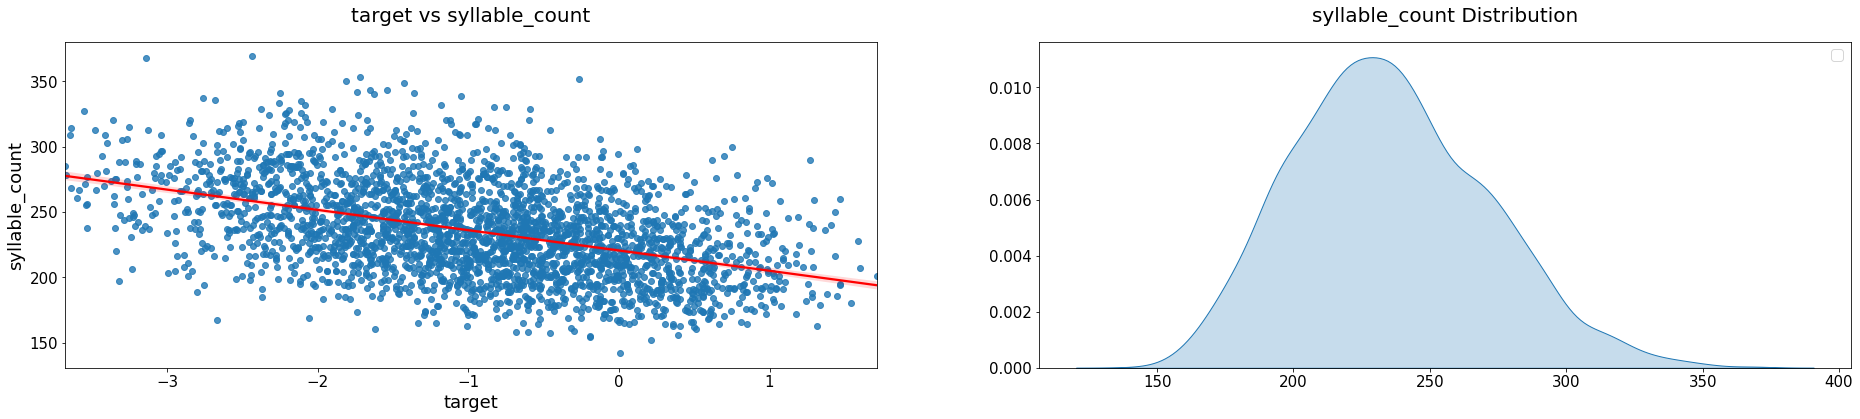

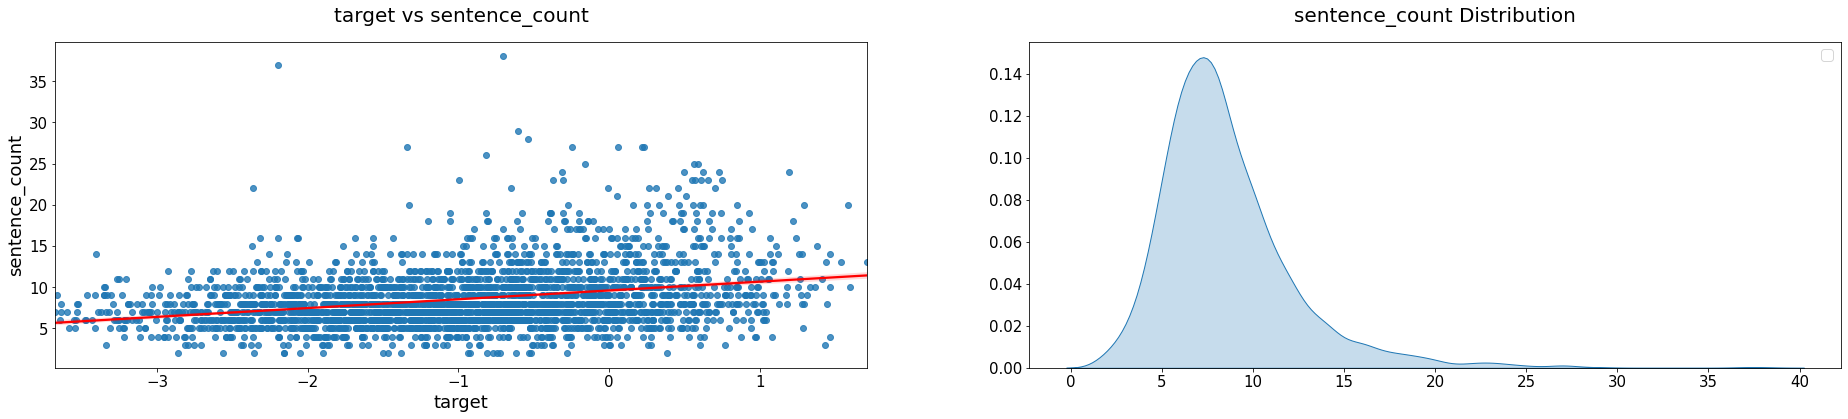

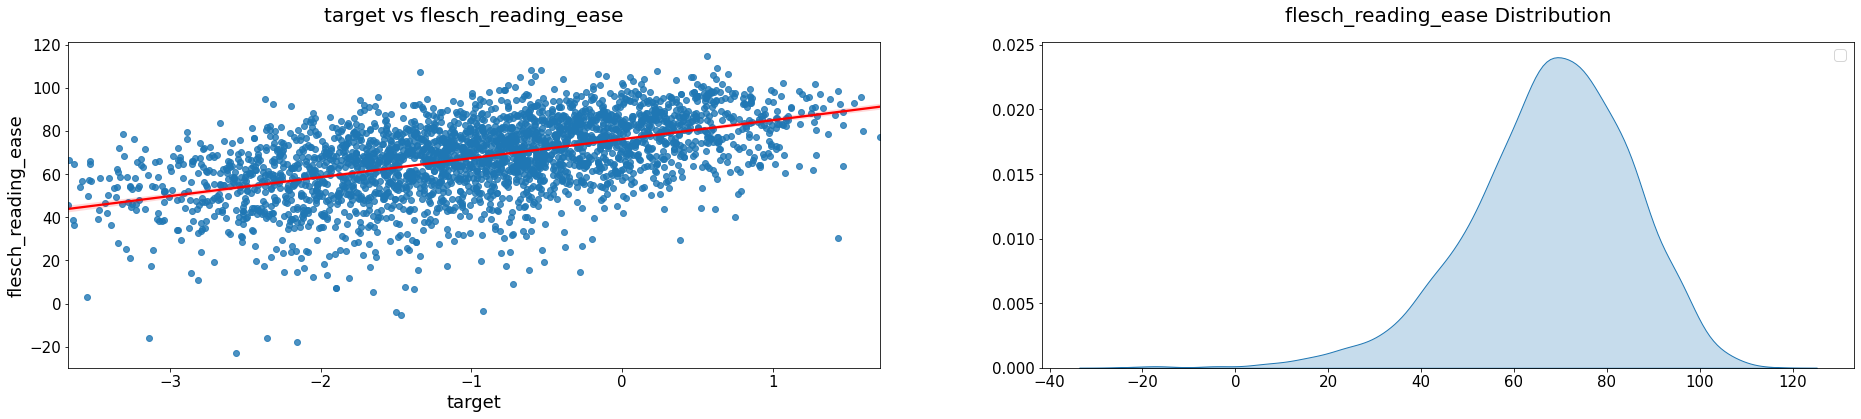

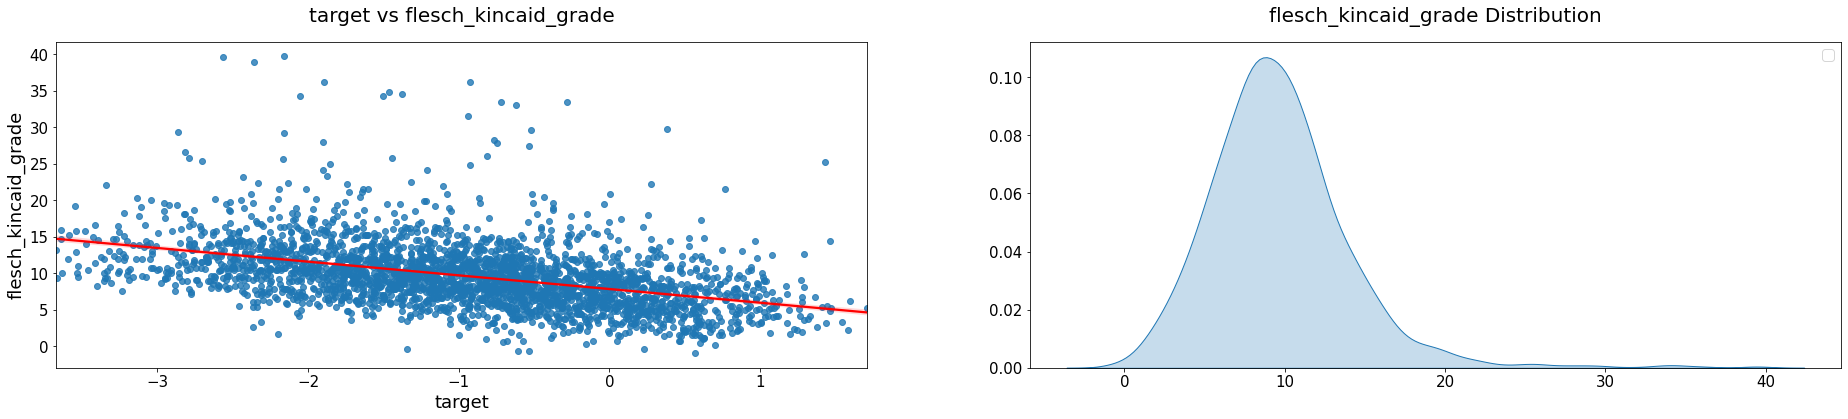

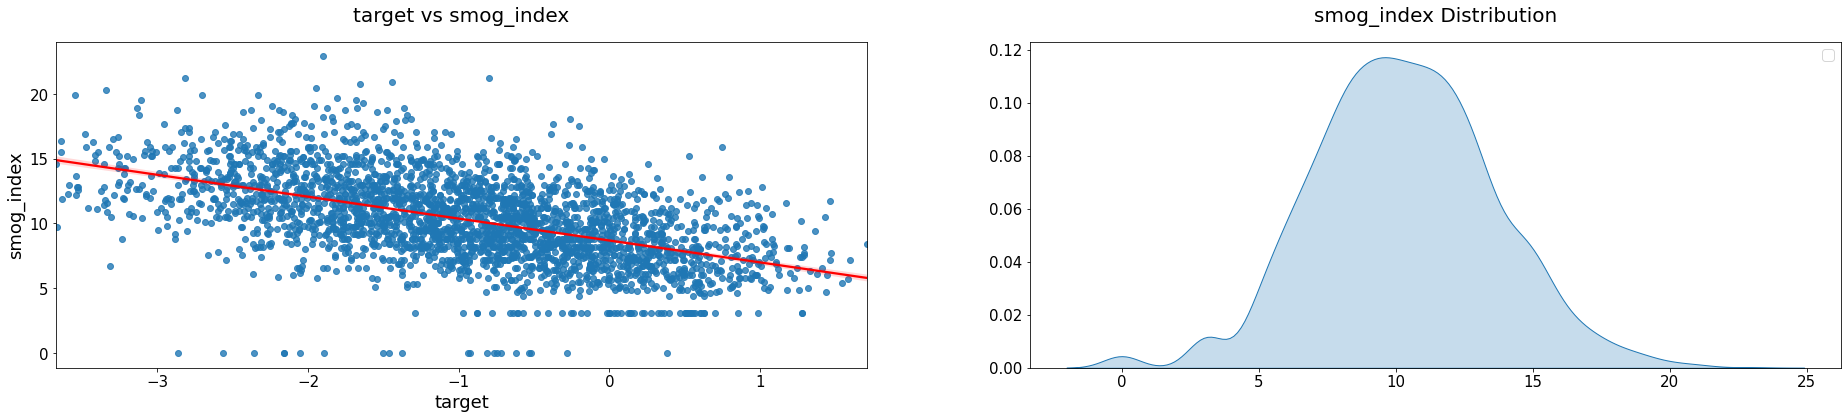

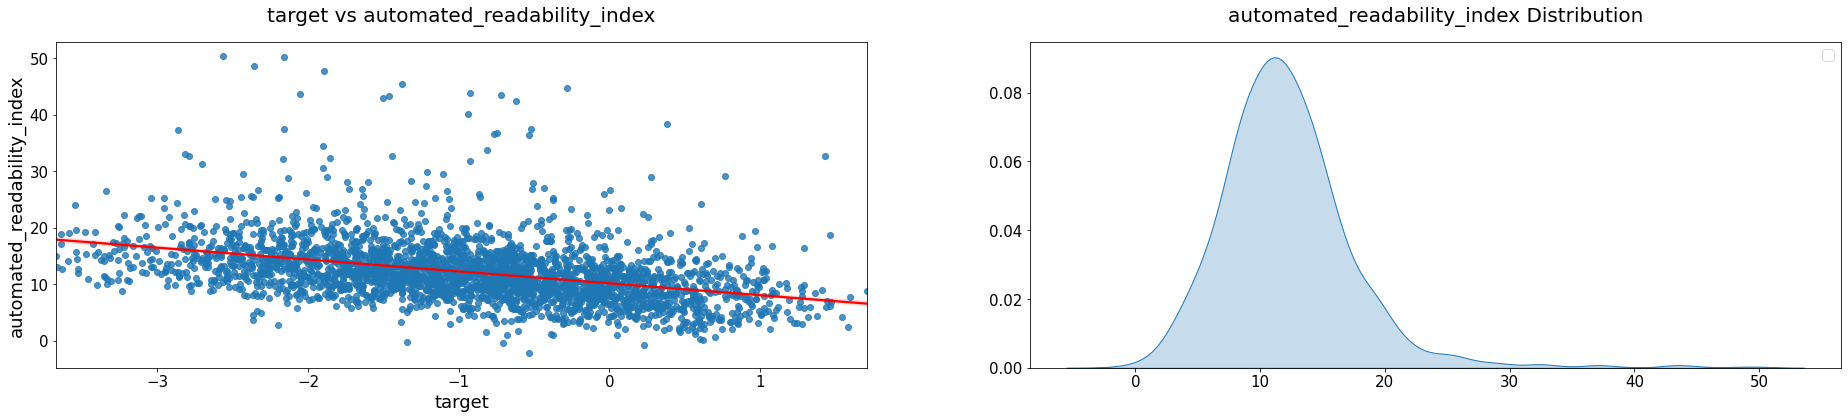

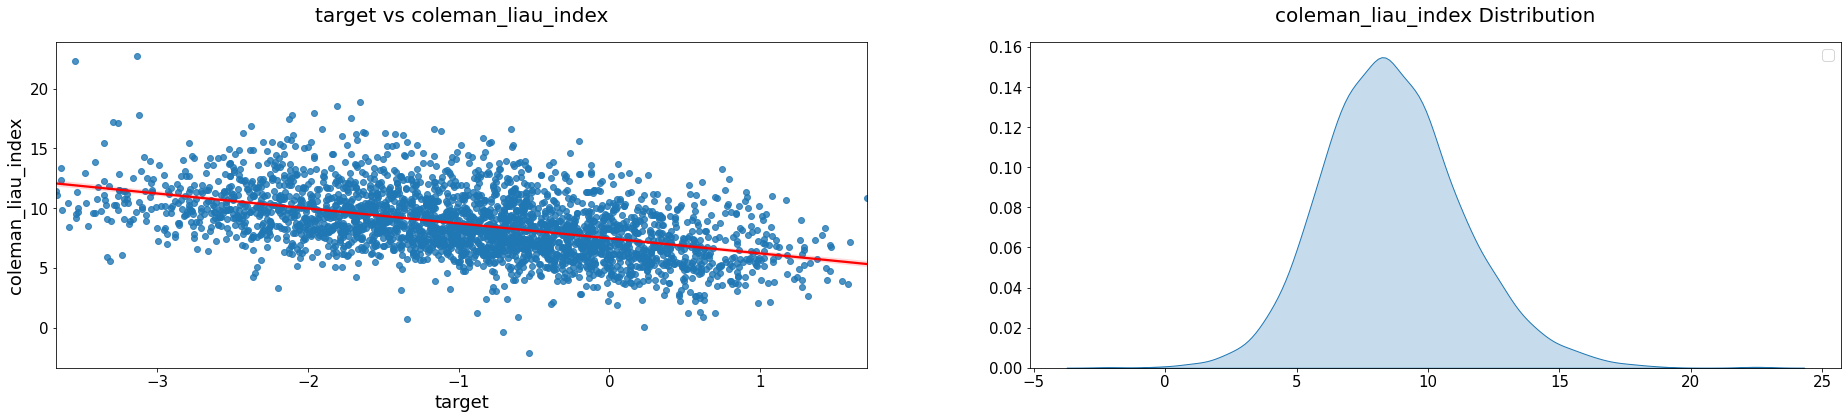

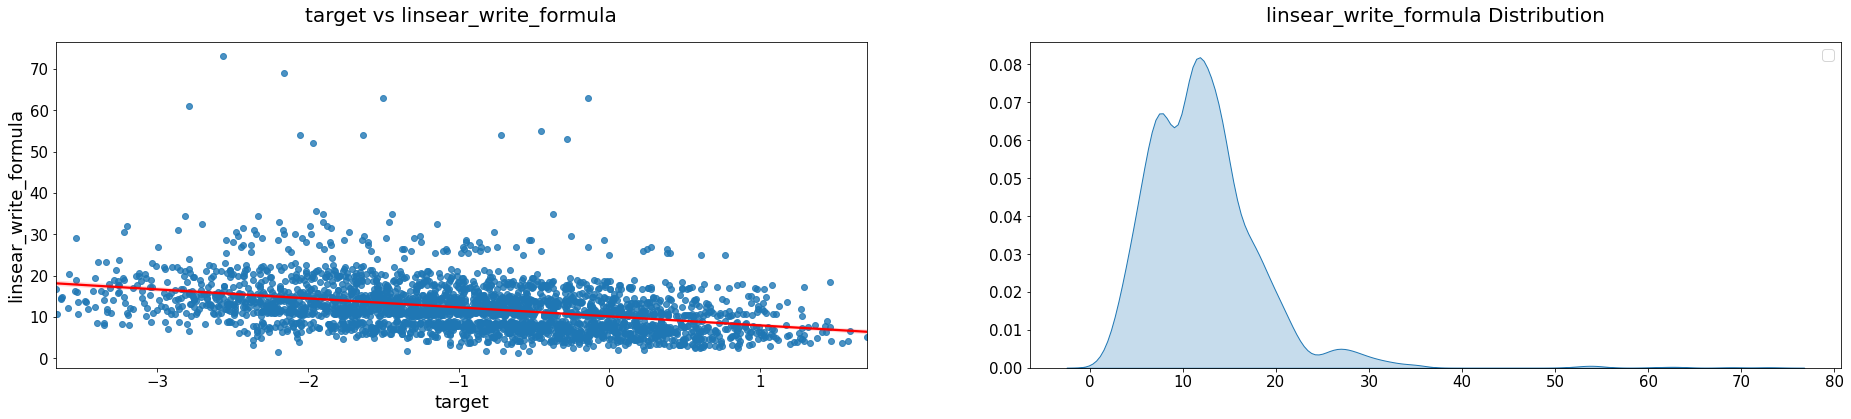

In [23]:
def plot_feature(feature):

    fig, axes = plt.subplots(ncols=2, figsize=(32, 6))

    sns.regplot(x=df_train['target'], y=df_train[feature], line_kws={'color': 'red'}, ax=axes[0])
    sns.kdeplot(df_train[feature], fill=True, ax=axes[1])

    axes[0].set_xlabel(f'target', size=18)
    axes[0].set_ylabel(feature, size=18)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].legend(prop={'size': 15})
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=15)
        axes[i].tick_params(axis='y', labelsize=15)
    axes[0].set_title(f'target vs {feature}', size=20, pad=20)
    axes[1].set_title(f'{feature} Distribution', size=20, pad=20)

    plt.show()
    
for feature in features:
    plot_feature(feature)

## 8. Word Embeddings

Most common source where the excerpts are taken is Wikipedia. We can use GloVe and fastText word embeddings for advanced data analysis since they are trained on Wikipedia corpus. 300 dimensional GloVe and fastText word embeddings are downloaded with `gensim` package, however the cell output has to suppressed since it continuously prints download status at high rate, and it might crash the notebook.

In [24]:
%%capture

fasttext_embeddings = api.load('fasttext-wiki-news-subwords-300')
glove_embeddings = api.load('glove-wiki-gigaword-300')

Both GloVe and fastText word embeddings have more than 85% vocabulary and 97% text coverage. It shows that excerpts are well written and there aren't many typos or unseen words in them. fastText and GloVe word embeddings have very close vocabulary and text coverage but GloVe is slightly higher.

In [25]:
def build_vocab(X):
    
    excerpts = X.apply(word_tokenize).values      
    vocab = {}
    
    for excerpt in excerpts:
        for word in excerpt:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab

def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(df_train['excerpt'].str.lower(), fasttext_embeddings)
glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(df_train['excerpt'].str.lower(), glove_embeddings)

print(f'fastText Embeddings cover {fasttext_vocab_coverage:.2%} of vocabulary and {fasttext_text_coverage:.2%} of text in Training Set')
print(f'GloVe Embeddings cover {glove_vocab_coverage:.2%} of vocabulary and {glove_text_coverage:.2%} of text in Training Set')

fastText Embeddings cover 85.41% of vocabulary and 97.63% of text in Training Set
GloVe Embeddings cover 86.20% of vocabulary and 99.07% of text in Training Set


Plotting words in OOVs with their frequencies can give some insights about proper data cleaning steps which should be applied. Most common words in fastText OOV are punctuations, but they are captured in GloVe. GloVe embeddings wasn't able to capture some words because they have dash (—) before or after them. Some of the phrases are not captured because they have hyphen (-) between the words. Those phrases should be dealt with in tokenization process.

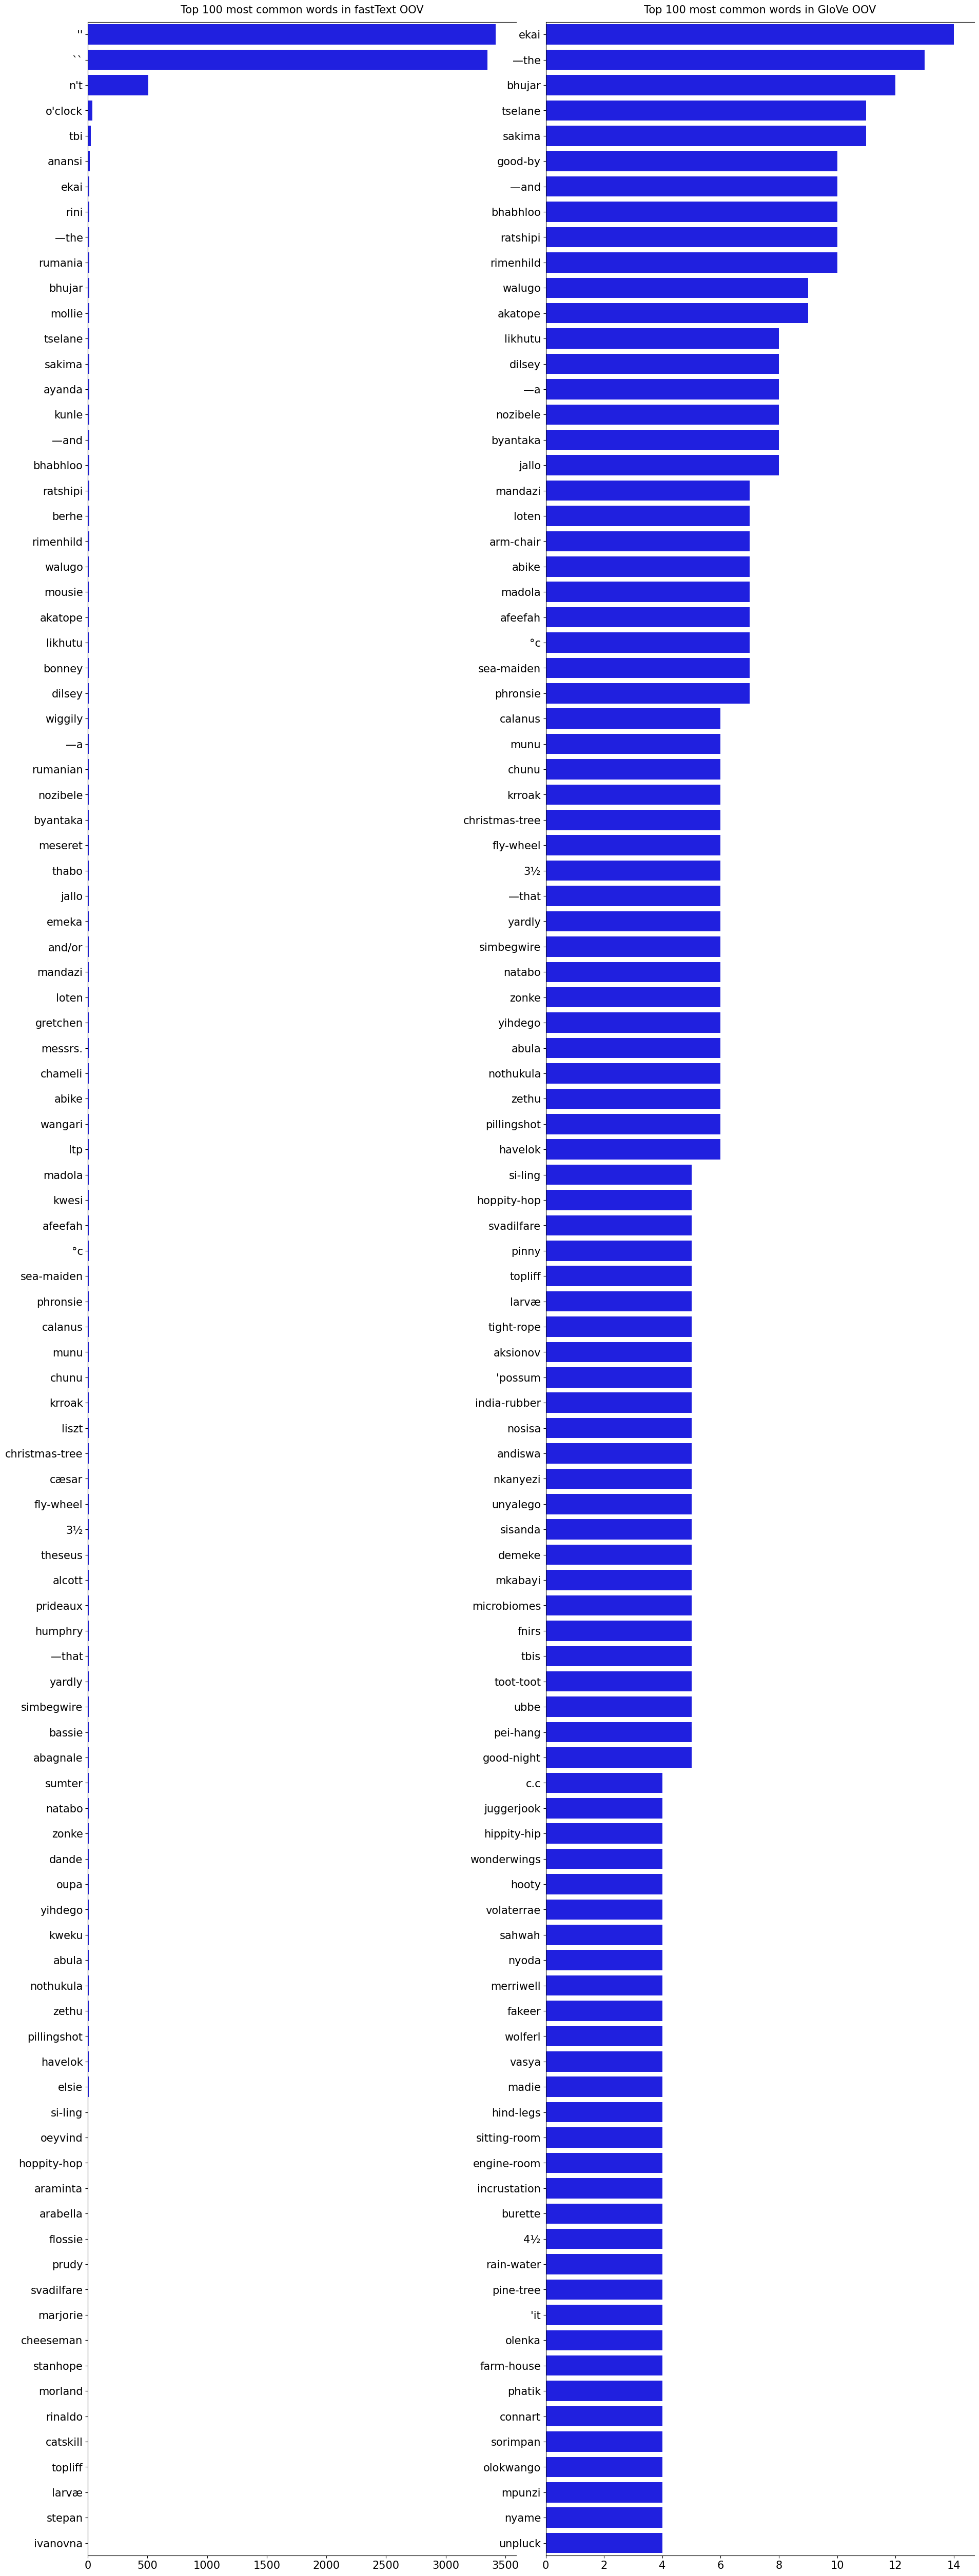

In [26]:
df_fasttext_oov = pd.DataFrame(fasttext_oov)
df_glove_oov = pd.DataFrame(glove_oov)

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_fasttext_oov[0].values[:n], x=df_fasttext_oov[1].values[:n], ax=axes[0], color='blue')
sns.barplot(y=df_glove_oov[0].values[:n], x=df_glove_oov[1].values[:n], ax=axes[1], color='blue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {n} most common words in fastText OOV', fontsize=15, pad=12)
axes[1].set_title(f'Top {n} most common words in GloVe OOV', fontsize=15, pad=12)

plt.show()

GloVe word embeddings are visualized with t-SNE in the cell below. First 200 words are selected for the visualization. Rendered image is very small but patterns can be seen when it is zoomed in.

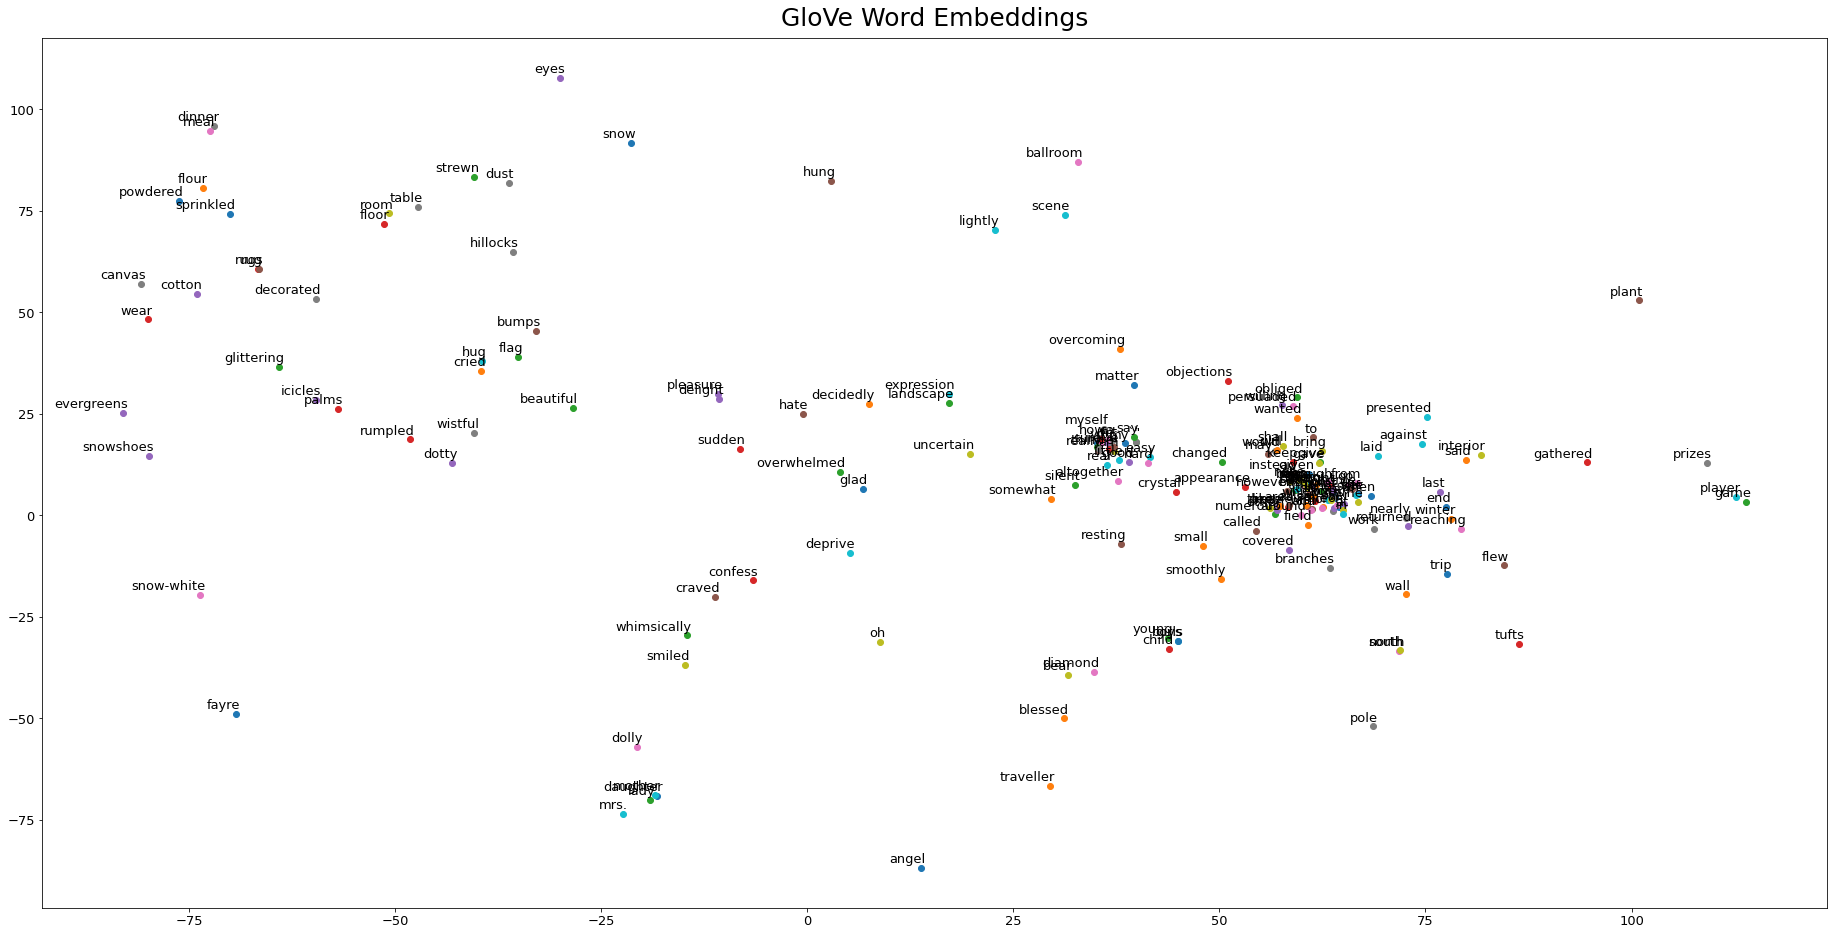

In [27]:
def plot_tsne(X, model):
    
    vocab = build_vocab(X)
    X_vectors = []
    words = []
    
    for word in vocab:
        try:
            X_vectors.append(model[word])
            words.append(word)
        except KeyError:
            continue
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    X_embedded = tsne_model.fit_transform(X_vectors)
        
    plt.figure(figsize=(32, 16)) 
    for i in range(len(X_embedded)):
        if i == 200:
            break
        plt.scatter(X_embedded[i, 0], X_embedded[i, 1])
        plt.annotate(words[i],
                     xy=(X_embedded[i, 0], X_embedded[i, 1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=13)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)
    plt.title(f'GloVe Word Embeddings', fontsize=25, pad=12)
    plt.show()
    
plot_tsne(df_train['excerpt'].str.lower(), glove_embeddings)